# Initial Setup

In [179]:
%%capture
%load_ext autoreload
%autoreload 2

import tqdm
from random import random
import pandas as pd
import matplotlib
import numpy as np
import csv
import itertools
import pickle as pkl

import time
import datetime
from dateutil.relativedelta import relativedelta
import pandas_market_calendars as mcal

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import quandl

from IPython.display import Audio
sound_file = '../sound/done.mp3'

import tbats
import pmdarima as pm
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error as mse

import prophet

from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier

import sys, os
code_path = '/code'
auth_path = '/auth'
if '..' + code_path not in sys.path:
    sys.path.insert(0, '..' + code_path)
if '..' + auth_path not in sys.path:
    sys.path.insert(0, '..' + auth_path)
current_path = os.getcwd()
sys.path

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
import matplotlib.units as munits
from matplotlib.dates import DateFormatter
# plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *
from regressions import *
from Pmdarima_Model import Pmdarima_Model

# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[date] = converter
munits.registry[datetime] = converter

from keys import client_id, secret_key, av_key, consumer_key, api_key

## Get NYSE calendar

In [2]:
NYSE = mcal.get_calendar('NYSE')

## Set up Frequency Variables

### Custom Business Hour

In [3]:
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')
cbh

<CustomBusinessHour: CBH=05:00-21:00>

### Custom Business Day

In [92]:
CBD = NYSE.holidays()
CBD

<CustomBusinessDay>

# YFinance Futures

## Setup / Gather Data

In [143]:
symbol = 'SPY'
f_symbol = 'ES=F'

In [144]:
years = [3, 5, 10, 20, 30]
get_yf_time_series(yf, years, symbol, freq=CBD)

In [145]:
years = [3, 5, 10, 20, 30]
get_yf_time_series(yf, years, f_symbol, freq=CBD, fut=True)

In [146]:
# spy_f_df = yf.download(symbol, start='2011-05-01', end='2021-05-01', progress=False)
# spy_f_df.index = spy_f_df.index.rename('date')
# spy_f_df.columns = ['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close', 'f_volume']
# spy_f_df.to_csv('../data/SPY_F_10Y_CBD.csv')

## Load Data from File

### 3Y

In [147]:
spy_df_3Y = load_yf_time_series(yf, 3, symbol, freq=CBD)
spy_f_df_3Y = load_yf_time_series(yf, 3, f_symbol, freq=CBD)

### 5Y

In [148]:
spy_df_5Y = load_yf_time_series(yf, 5, symbol, freq=CBD)
spy_f_df_5Y = load_yf_time_series(yf, 5, f_symbol, freq=CBD)

### 10Y

In [149]:
spy_df_10Y = load_yf_time_series(yf, 10, symbol, freq=CBD)
spy_f_df_10Y = load_yf_time_series(yf, 10, f_symbol, freq=CBD)

## 20Y

In [256]:
spy_df_20Y = load_yf_time_series(yf, 20, symbol, freq=CBD)
spy_f_df_20Y = load_yf_time_series(yf, 20, f_symbol, freq=CBD)

### All

In [14]:
spy_df_all = load_yf_time_series(yf, 30, symbol, freq=CBD)
spy_f_df_all = load_yf_time_series(yf, 30, f_symbol, freq=CBD)

In [252]:
spy_f_df_all

Pmdarima_Model.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data..


,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2000-09-18,1485.25,1489.75,1462.25,1467.50,1467.50,104794.0
2000-09-19,1467.00,1482.75,1466.75,1478.50,1478.50,103371.0
2000-09-20,1478.75,1480.50,1450.25,1469.50,1469.50,109667.0
2000-09-21,1470.25,1474.00,1455.50,1469.50,1469.50,98528.0
2000-09-22,1454.75,1471.00,1436.75,1468.50,1468.50,97416.0
...,...,...,...,...,...,...
2021-05-04,4184.25,4185.50,4120.50,4158.25,4158.25,2003587.0
2021-05-05,4158.25,4180.00,4153.00,4160.00,4160.00,1418246.0
2021-05-06,4158.75,4197.25,4140.50,4194.25,4194.25,1751616.0


### Treasury Yield Curve

In [15]:
# tsy_df = pd.read_csv('../data/10-year-treasury-bond-rate-yield-chart.csv', index_col='date')
# tsy_df.dropna(inplace=True)
# tsy_df.index = pd.to_datetime(tsy_df.index)
# tsy_df.columns = ['value']

In [16]:
# tsy_all_df = tsy_df.sort_index().truncate(before=spy_df_all.index[0], after=spy_df_all.index[-1])
# tsy_10Y_df = tsy_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
# tsy_5Y_df = tsy_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
# tsy_3Y_df = tsy_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

#### Using Quandl

In [64]:
tsy_symbol = 'USTREASURY/YIELD'

In [65]:
tsy_df = quandl.get(tsy_symbol)
tsy_all_df = tsy_df.copy()
tsy_all_df.index.name = 'date'

In [66]:
tsy_all_df = tsy_all_df.sort_index().truncate(before=spy_df_all.index[0], after=spy_df_all.index[-1])
tsy_10Y_df = tsy_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
tsy_5Y_df = tsy_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
tsy_3Y_df = tsy_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

In [20]:
tsy_all_df.isna().sum()

1 MO     2130
2 MO     6435
3 MO        3
6 MO        0
1 YR        0
2 YR        0
3 YR        0
5 YR        0
7 YR        0
10 YR       0
20 YR     170
30 YR     994
dtype: int64

In [67]:
tsy_3Y_df = tsy_3Y_df.asfreq(CBD).interpolate()
tsy_5Y_df = tsy_5Y_df.asfreq(CBD).interpolate()
tsy_10Y_df = tsy_10Y_df.asfreq(CBD).interpolate()
tsy_all_df = tsy_all_df.asfreq(CBD).interpolate()

In [22]:
tsy_all_df_6M = tsy_all_df['6 MO']
tsy_all_df_1Y = tsy_all_df['1 YR']
tsy_all_df_2Y = tsy_all_df['2 YR']
tsy_all_df_3Y = tsy_all_df['3 YR']
tsy_all_df_5Y = tsy_all_df['5 YR']
tsy_all_df_7Y = tsy_all_df['7 YR']
tsy_all_df_10Y = tsy_all_df['10 YR']

In [23]:
tsy_3Y_df_10Y = tsy_3Y_df['3 YR']

In [70]:
tsy_10Y_df_10Y = tsy_10Y_df['10 YR']
tsy_10Y_df_10Y

date
2011-05-02    3.31
2011-05-03    3.28
2011-05-04    3.25
2011-05-05    3.18
2011-05-06    3.19
              ... 
2021-05-04    1.61
2021-05-05    1.59
2021-05-06    1.58
2021-05-07    1.60
2021-05-10    1.63
Freq: C, Name: 10 YR, Length: 2523, dtype: float64

In [69]:
tsy_all_df_10Y

date
1993-01-29    6.39
1993-02-01    6.38
1993-02-02    6.46
1993-02-03    6.45
1993-02-04    6.39
              ... 
2021-05-04    1.61
2021-05-05    1.59
2021-05-06    1.58
2021-05-07    1.60
2021-05-10    1.63
Freq: C, Name: 10 YR, Length: 7121, dtype: float64

In [26]:
tsy_all_df_10Y.corr(spy_df_all.close)

-0.7377448269529822

In [27]:
tsy_df['1 MO'].corr(spy_df_all.close)

-0.1288181652050397

In [28]:
tsy_df['2 MO'].corr(spy_df_all.close)

-0.6641939565384585

In [29]:
tsy_df['3 MO'].corr(spy_df_all.close)

-0.4306547850770101

In [30]:
tsy_df['6 MO'].corr(spy_df_all.close)

-0.4408205175791185

In [31]:
tsy_df['1 YR'].corr(spy_df_all.close)

-0.465399716776765

In [32]:
tsy_df['2 YR'].corr(spy_df_all.close)

-0.5134164747430139

In [253]:
tsy_df['3 YR'].corr(spy_df_3Y.close)

Functions.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


-0.6855353742479489

In [254]:
tsy_df['5 YR'].corr(spy_df_5Y.close)

-0.4128951858452942

In [35]:
tsy_df['7 YR'].corr(spy_df_all.close)

-0.6793020921197513

In [36]:
tsy_df['10 YR']

Date
1990-01-02    7.94
1990-01-03    7.99
1990-01-04    7.98
1990-01-05    7.99
1990-01-08    8.02
              ... 
2021-05-04    1.61
2021-05-05    1.59
2021-05-06    1.58
2021-05-07    1.60
2021-05-10    1.63
Name: 10 YR, Length: 7845, dtype: float64

In [271]:
tsy_df['10 YR'].corr(spy_df_10Y.close)

-0.30960540810280657

In [257]:
tsy_df['20 YR'].corr(spy_df_20Y.close)

-0.7581693921631996

In [39]:
tsy_df['30 YR'].corr(spy_df_all.close)

-0.8175303222065133

#### Inflation Indexed

In [40]:
tsy_ii_symbol = 'FRED/DFII10'
tsy_ii_df = quandl.get(tsy_ii_symbol)
tsy_ii_df

,Value
Date,
2003-01-02,2.43
2003-01-03,2.43
2003-01-06,2.46
2003-01-07,2.42
2003-01-08,2.29
...,...
2021-05-03,-0.79
2021-05-04,-0.81
2021-05-05,-0.88


### Fed Funds Rate

In [41]:
# fed_df = pd.read_csv('../data/fed-funds-rate-historical-chart.csv', index_col='date')
# fed_df.dropna(inplace=True)
# fed_df.index = pd.to_datetime(fed_df.index)
# fed_df.columns = ['value']

In [42]:
# fed_all_df = fed_df.sort_index().truncate(before=spy_df_all.index[0],after=spy_df_all.index[-1])
# fed_10Y_df = fed_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
# fed_5Y_df = fed_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
# fed_3Y_df = fed_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

#### Quandl

In [102]:
# fed_symbol = 'FRED/FEDFUNDS'
fed_symbol_daily = 'FRED/DFF'
# fed_df = quandl.get(fed_symbol)
fed_df = quandl.get(fed_symbol_daily)
fed_df = fed_df.Value
fed_df.index.name = 'date'
fed_df.name = 'value'
fed_df.isna().sum()

0

In [103]:
fed_df

date
1954-07-01    1.13
1954-07-02    1.25
1954-07-03    1.25
1954-07-04    1.25
1954-07-05    0.88
              ... 
2021-05-06    0.06
2021-05-07    0.06
2021-05-08    0.06
2021-05-09    0.06
2021-05-10    0.06
Name: value, Length: 24421, dtype: float64

In [104]:
fed_all_df = fed_df.sort_index().truncate(before=spy_df_all.index[0],after=spy_df_all.index[-1])
fed_10Y_df = fed_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
fed_5Y_df = fed_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
fed_3Y_df = fed_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

In [105]:
fed_all_df = fed_all_df.asfreq(CBD)
fed_10Y_df = fed_10Y_df.asfreq(CBD)
fed_5Y_df = fed_5Y_df.asfreq(CBD)
fed_3Y_df = fed_3Y_df.asfreq(CBD)

In [106]:
fed_all_df.isna().sum(), fed_10Y_df.isna().sum(), fed_5Y_df.isna().sum(), fed_3Y_df.isna().sum()

(0, 0, 0, 0)

### Fed Funds Target Rate - Upper Limit

In [48]:
# only available from 2008
fed_fund_target = 'FRED/DFEDTARU'
fed_t_df = quandl.get(fed_fund_target)
fed_t_df.columns = ['value']
fed_t_df.index.name = 'date'
fed_t_df

,value
date,
2008-12-16,0.25
2008-12-17,0.25
2008-12-18,0.25
2008-12-19,0.25
2008-12-20,0.25
...,...
2021-05-05,0.25
2021-05-06,0.25
2021-05-07,0.25


In [49]:
fed_t_all_df = fed_t_df.sort_index().truncate(before=spy_df_all.index[0],after=spy_df_all.index[-1])
fed_t_10Y_df = fed_t_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
fed_t_5Y_df = fed_t_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
fed_t_3Y_df = fed_t_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

In [50]:
fed_t_all_df = fed_t_all_df.asfreq(CBD)
fed_t_10Y_df = fed_t_10Y_df.asfreq(CBD)
fed_t_5Y_df = fed_t_5Y_df.asfreq(CBD)
fed_t_3Y_df = fed_t_3Y_df.asfreq(CBD)

In [51]:
fed_t_all_df.isna().sum(), fed_t_10Y_df.isna().sum(), fed_t_5Y_df.isna().sum(), fed_t_3Y_df.isna().sum()

(value    0
 dtype: int64,
 value    0
 dtype: int64,
 value    0
 dtype: int64,
 value    0
 dtype: int64)

## Data Preparation

### EDA

In [55]:
spy_f_df_3Y

,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2018-05-01,2646.25,2658.00,2623.25,2652.25,2652.25,1323628
2018-05-02,2655.50,2658.50,2624.25,2627.50,2627.50,1427995
2018-05-03,2626.75,2636.25,2591.25,2631.75,2631.75,2146587
2018-05-04,2631.75,2669.50,2612.25,2663.00,2663.00,1699202
2018-05-07,2662.75,2681.50,2661.25,2670.00,2670.00,1148919
...,...,...,...,...,...,...
2021-05-03,4181.50,4202.50,4181.00,4185.75,4185.75,1256240
2021-05-04,4184.25,4185.50,4120.50,4158.25,4158.25,2003587
2021-05-05,4158.25,4180.00,4153.00,4160.00,4160.00,1418246


In [56]:
spy_df_3Y.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

In [65]:
tsy_3Y_df

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
date,,,,,,,,,,,,
2018-05-01,1.68,NaN,1.85,2.05,2.26,2.50,2.66,2.82,2.93,2.97,3.03,3.13
2018-05-02,1.69,NaN,1.84,2.03,2.24,2.49,2.64,2.80,2.92,2.97,3.04,3.14
2018-05-03,1.68,NaN,1.84,2.02,2.24,2.49,2.62,2.78,2.90,2.94,3.02,3.12
2018-05-04,1.67,NaN,1.84,2.03,2.24,2.51,2.63,2.78,2.90,2.95,3.02,3.12
2018-05-07,1.69,NaN,1.86,2.05,2.25,2.49,2.64,2.78,2.90,2.95,3.02,3.12
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,0.02,0.02,0.04,0.04,0.06,0.16,0.33,0.84,1.29,1.63,2.18,2.30
2021-05-04,0.01,0.01,0.02,0.04,0.06,0.16,0.33,0.82,1.28,1.61,2.16,2.27
2021-05-05,0.01,0.01,0.02,0.04,0.06,0.16,0.32,0.80,1.25,1.59,2.14,2.25


In [122]:
df_10Y_close

date
2011-05-02    136.220001
2011-05-03    135.729996
2011-05-04    134.830002
2011-05-05    133.610001
2011-05-06    134.199997
                 ...    
2021-05-04    415.619995
2021-05-05    415.750000
2021-05-06    419.070007
2021-05-07    422.119995
2021-05-10    417.940002
Name: close, Length: 2523, dtype: float64

In [121]:
df_f_10Y_close

date
2011-05-02    1357.75
2011-05-03    1352.00
2011-05-04    1343.00
2011-05-05    1335.00
2011-05-06    1334.50
               ...   
2021-05-04    4158.25
2021-05-05    4160.00
2021-05-06    4194.25
2021-05-07    4225.25
2021-05-10    4183.50
Name: f_close, Length: 2501, dtype: float64

In [120]:
tsy_10Y_df_10Y

date
2011-05-02    3.31
2011-05-03    3.28
2011-05-04    3.25
2011-05-05    3.18
2011-05-06    3.19
              ... 
2021-05-04    1.61
2021-05-05    1.59
2021-05-06    1.58
2021-05-07    1.60
2021-05-10    1.63
Freq: C, Name: 10 YR, Length: 2523, dtype: float64

In [119]:
fed_10Y_df

date
2011-05-02    0.09
2011-05-03    0.09
2011-05-04    0.09
2011-05-05    0.09
2011-05-06    0.09
              ... 
2021-05-04    0.06
2021-05-05    0.06
2021-05-06    0.06
2021-05-07    0.06
2021-05-10    0.06
Freq: C, Name: value, Length: 2523, dtype: float64

In [108]:
kwargs = {'data':[df_10Y_close, df_f_10Y_close, tsy_10Y_df_10Y, fed_10Y_df]}

In [110]:
data = [df_10Y_close, df_f_10Y_close, tsy_10Y_df_10Y, fed_10Y_df]

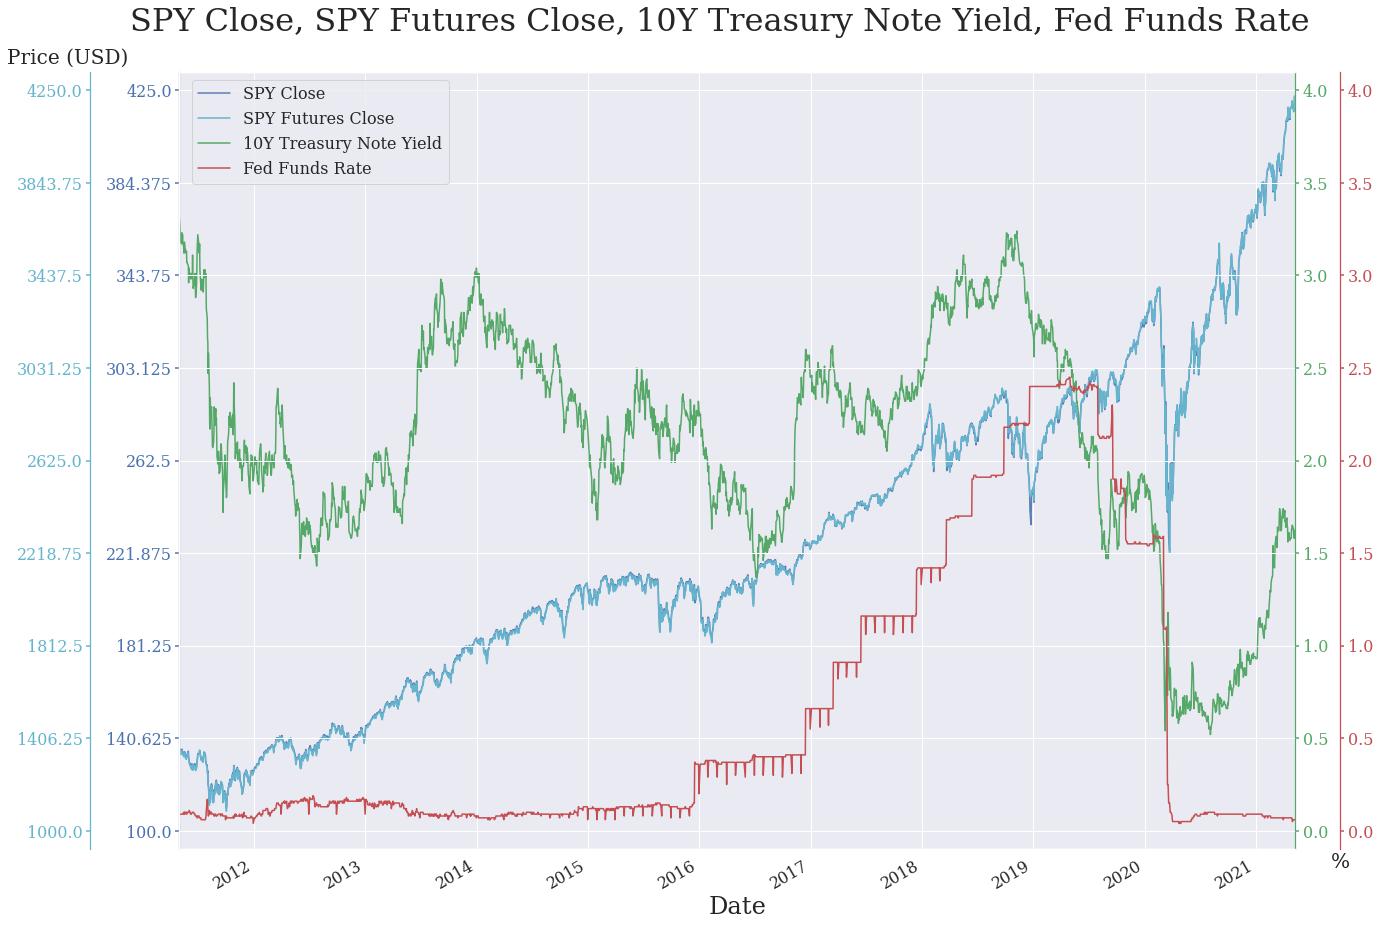

In [139]:
# plot_spy_fut_tsy_funds_time_series(**kwargs)
plot_spy_fut_tsy_funds_time_series(data)

In [ ]:
# fig, ax1 = plt.subplots(figsize=(20,15))
# axes = [ax1, ax2, ax3, ax4]
# data = [spy_df_3Y.close, spy_f_df_3Y.f_close, tsy_3Y_df.value, fed_3Y_df.value]
# colors = ['b','c','g','r']
# labels = ['SPY 3Y Close', 'SPY Futures 3Y Close', '10Y Treasury Yield', 'Fed Funds Rate']
# ylabels = ['SPY 3Y Close (USD)', 'SPY Futures 3Y Close (USD)', '10Y Treasury Yield %', 'Fed Funds Rate %']
# alpha = [0.9, 1, 1, 1]
# spy_range = (225, 425)
# yield_range = (0, 4)
# num_ticks = 9
# y_ranges = [spy_range, [10*x for x in spy_range], yield_range, yield_range]
# tkw = dict(size=4, width=1.5, labelsize=16)
# for n, ax in enumerate(axes):
#     if n>0:
#         ax = ax1.twinx()
#     if n==1:
#         ax.spines['left'].set_position(("axes", -0.06))
#         ax.spines['left'].set_edgecolor(colors[n])
#         ax.yaxis.set_label_position("left")
#         ax.yaxis.tick_left()
#     if n>1:
#         ax.spines['right'].set_position(("axes", 1 + 0.04*(n-2)))
#         ax.spines['right'].set_edgecolor(colors[n])
#     data[n].plot(ax=ax, color=colors[n], alpha=alpha[n], label=labels[n])
#     y_ticks = np.linspace(y_ranges[n][0], y_ranges[n][1], num_ticks)
#     pad = (y_ranges[n][1] - y_ranges[n][0]) / (num_ticks-1)/5
#     y_lim = (y_ranges[n][0]-pad, y_ranges[n][1]+pad)
#     ax.set_yticklabels(y_ticks)
#     ax.set_yticks(y_ticks)
#     ax.set_ylim(y_lim)
#     ax.tick_params(axis='y', colors=colors[n], **tkw)

# ax1.set_xlabel('Date', size=24)
# ax1.tick_params(axis='x', **tkw)
# fig.suptitle(', '.join(labels), size=32)
# fig.subplots_adjust(top=0.92)
# fig.legend(loc=(0.139, 0.8007), prop={"size":16})
# plt.savefig(f'{TOP}/images/SPY_3Y_Comparison_Graph.png')
# # fig.legend(loc='upper left', borderaxespad=7)

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,15))
spy_df_3Y.close.plot(ax=ax1, color ='b', label='SPY 3Y Close')
ax1.tick_params(axis='y', colors='b')
ax1.set_ylim(x1_range)
x1_range = (200,425)
ax1.set_yticklabels(np.arange(x1_range[0],x1_range[1],11))

ax2 = ax1.twinx()
spy_f_df_3Y.f_close.plot(ax=ax2, color = 'r', label='SPY Futures 3Y Close')
ax2.tick_params(axis='y', colors='r')
x2_range = (2000,4250)
ax2.set_yticklabels(np.arange(x2_range[0],x2_range[1],11))

ax3 = ax1.twinx()
tsy_3Y_df.value.plot(ax=ax3, color = 'g', label='10Y Treasury Yield')
ax3.tick_params(axis='y', colors='g')

ax4 = ax1.twinx()
fed_3Y_df.value.plot(ax=ax4, color = 'darkorange', label='Fed Funds Rate')
ax4.tick_params(axis='y', colors='darkorange')
ax4.set_ylim(-0.05, 2.55)

fig.suptitle('SPY Closing, SPY Futures Close, 10Y Treasury Yield, Fed Funds Rate', size=24)
fig.subplots_adjust(top=0.95)
fig.legend(loc=(0.65, 0.85))

In [98]:
spy_df_10Y.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

In [99]:
spy_f_df_10Y

,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2011-05-02,1363.25,1373.50,1354.75,1357.75,1357.75,1707040.0
2011-05-03,1357.75,1358.50,1345.75,1352.00,1352.00,1674060.0
2011-05-04,1351.75,1355.00,1337.50,1343.00,1343.00,2382666.0
2011-05-05,1343.25,1348.75,1325.25,1335.00,1335.00,2915006.0
2011-05-06,1334.25,1351.75,1331.75,1334.50,1334.50,2673077.0
...,...,...,...,...,...,...
2021-05-04,4184.25,4185.50,4120.50,4158.25,4158.25,2003587.0
2021-05-05,4158.25,4180.00,4153.00,4160.00,4160.00,1418246.0
2021-05-06,4158.75,4197.25,4140.50,4194.25,4194.25,1751616.0


In [ ]:
spy_df_3Y.index[-1]

In [ ]:
spy_df_5Y.truncate(before=spy_df_3Y.index[0])

### Set up Frequency

In [94]:
spy_df_3Y = spy_df_3Y.asfreq(CBD)
spy_df_5Y = spy_df_5Y.asfreq(CBD)
spy_df_10Y = spy_df_10Y.asfreq(CBD)
spy_df_all = spy_df_all.asfreq(CBD)

In [95]:
spy_f_df_3Y = spy_f_df_3Y.asfreq(CBD)
spy_f_df_5Y = spy_f_df_5Y.asfreq(CBD)
spy_f_df_10Y = spy_f_df_10Y.asfreq(CBD)
spy_f_df_all = spy_f_df_all.asfreq(CBD)

In [117]:
spy_df_all.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

In [116]:
spy_f_df_all.isna().sum()

f_open         35
f_high         35
f_low          35
f_close        35
f_adj_close    35
f_volume       35
dtype: int64

In [ ]:
tsy_df = tsy_df.asfreq(CBD)

In [ ]:
tsy_df[tsy_df['10 YR'].isna()]['10 YR']

In [ ]:
spy_df_3Y.isna().sum(), spy_df_5Y.isna().sum(), spy_df_10Y.isna().sum(), spy_df_25Y.isna().sum()

In [ ]:
spy_f_df_5Y[spy_f_df_5Y.f_close.isna()]

### Impute Missing Values

In [96]:
spy_f_df_3Y = spy_f_df_3Y.interpolate()
spy_f_df_5Y = spy_f_df_5Y.interpolate()
spy_f_df_10Y = spy_f_df_10Y.interpolate()
spy_f_df_all = spy_f_df_all.interpolate()

### Create Time Series for `Close`, `Volume`

In [150]:
df_3Y_close = spy_df_3Y.close
df_3Y_vol = spy_df_3Y.volume
df_5Y_close = spy_df_5Y.close
df_5Y_vol = spy_df_5Y.volume
df_10Y_close = spy_df_10Y.close
df_10Y_vol = spy_df_10Y.volume
df_all_close = spy_df_all.close
df_all_vol = spy_df_all.volume

df_f_3Y_close = spy_f_df_3Y.f_close
df_f_3Y_vol = spy_f_df_3Y.f_volume
df_f_5Y_close = spy_f_df_5Y.f_close
df_f_5Y_vol = spy_f_df_5Y.f_volume
df_f_10Y_close = spy_f_df_10Y.f_close
df_f_10Y_vol = spy_f_df_10Y.f_volume
df_f_all_close = spy_f_df_all.f_close
df_f_all_vol = spy_f_df_all.f_volume

In [123]:
df_f_5Y_close, df_f_5Y_vol

(date
 2016-05-02    2074.25
 2016-05-03    2057.00
 2016-05-04    2047.00
 2016-05-05    2044.00
 2016-05-06    2052.75
                ...   
 2021-05-03    4185.75
 2021-05-04    4158.25
 2021-05-05    4160.00
 2021-05-06    4194.25
 2021-05-07    4225.25
 Freq: C, Name: f_close, Length: 1264, dtype: float64,
 date
 2016-05-02    1306173.0
 2016-05-03    1827577.0
 2016-05-04    1557981.0
 2016-05-05    1433289.0
 2016-05-06    1813432.0
                 ...    
 2021-05-03    1256240.0
 2021-05-04    2003587.0
 2021-05-05    1418246.0
 2021-05-06    1751616.0
 2021-05-07    1751616.0
 Freq: C, Name: f_volume, Length: 1264, dtype: float64)

## Data Exploration

### Plot PACF

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



NameError: name 'top' is not defined

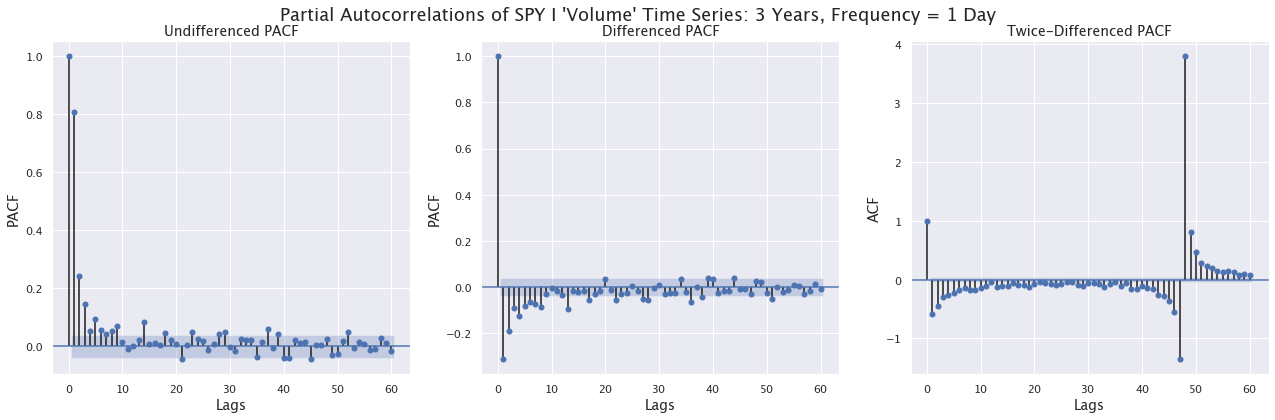

In [155]:
plot_pacf_with_diff(df_10Y_vol, 'SPY I \'Volume\'', 3, 'years', '1 Day', lags=60)

In [141]:
plot_pacf_with_diff(df_10Y_close, 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

NameError: name 'df_full_10Y_close' is not defined

### Plot ACF

In [140]:
plot_acf_with_diff(df_full_3Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

NameError: name 'df_full_3Y_vol' is not defined

In [1]:
plot_acf_with_diff(df_full_all_close, 'SPY \'Close\'', 28, 'years', '1 Day', lags=60)

NameError: name 'plot_acf_with_diff' is not defined

### Plot Seasonal Decomposition

#### 3 Years, Freq = Custom Business Day, Yearly Seasonality

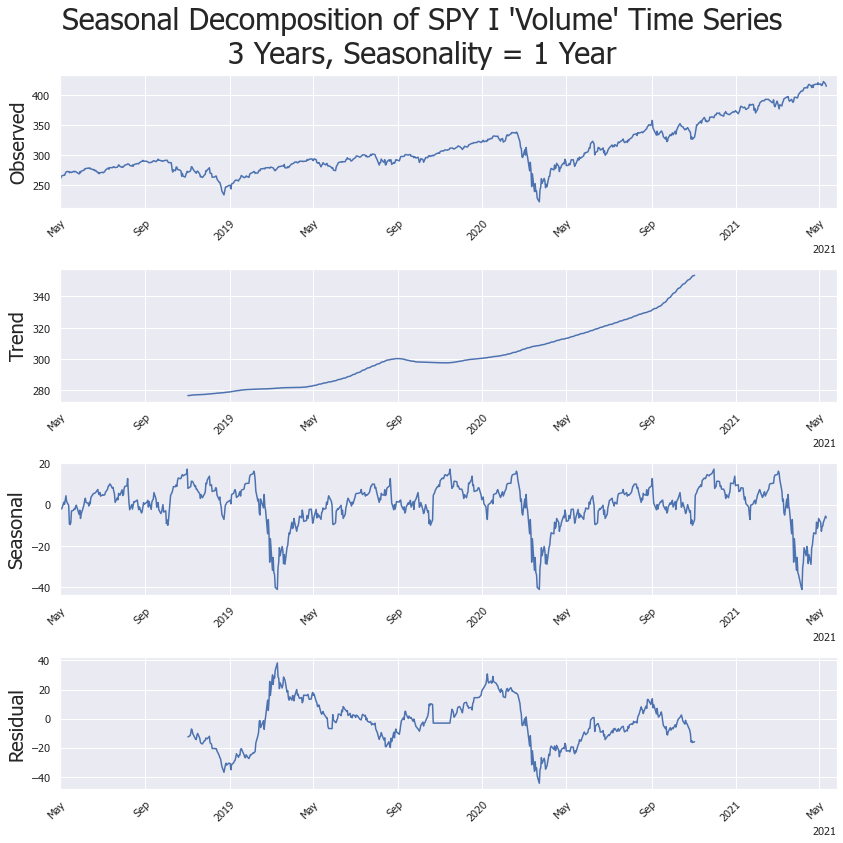

In [158]:
plot_seasonal_decomposition(df_3Y_close, 'SPY I \'Volume\'', 3, 'years', '1 Day', 261)

#### 5 Years, Freq = Custom Business Day, Yearly Seasonality

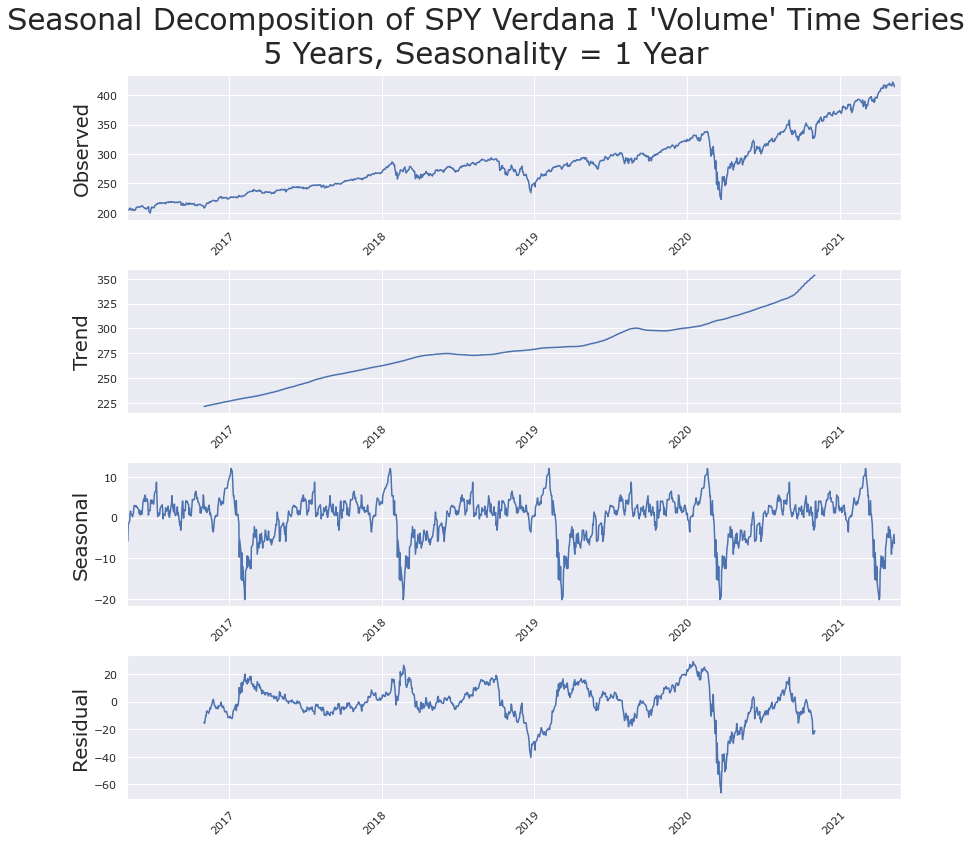

In [160]:
plot_seasonal_decomposition(df_5Y_close.dropna(), 'SPY Verdana I \'Volume\'', 5, 'years', '1 Day', 261)

#### 10 Years, Freq = Custom Business Day, Yearly Seasonality

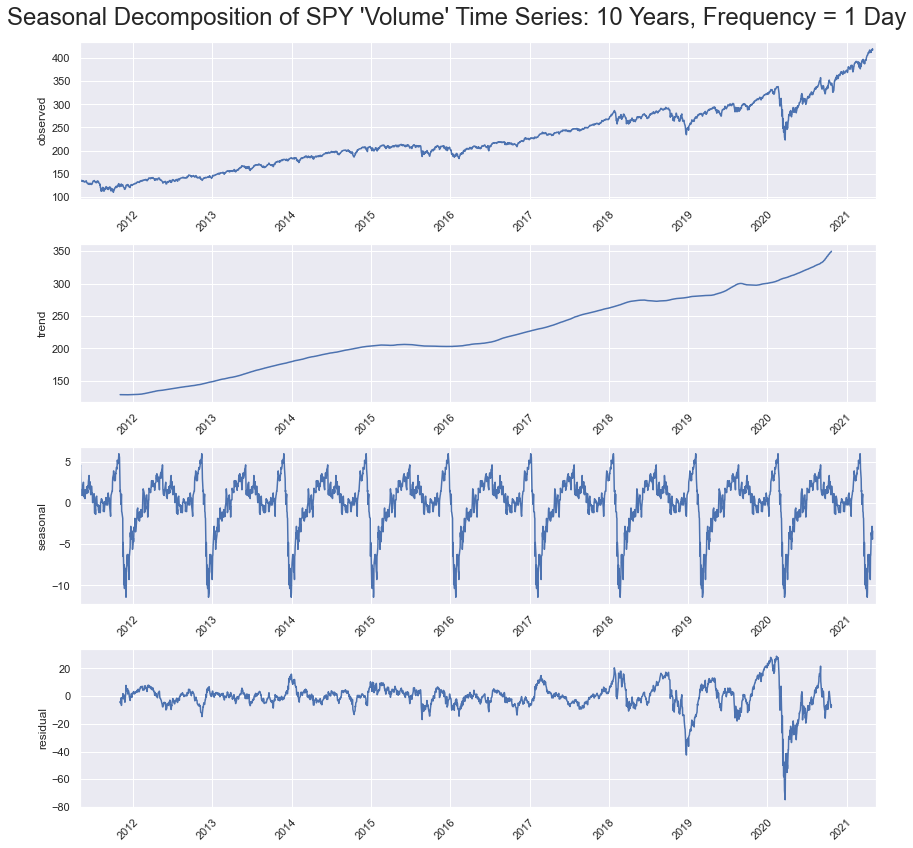

In [25]:
plot_seasonal_decomposition(df_full_10Y_close.dropna(), 'SPY \'Volume\'', 10, 'years', '1 Day', 261)

### Build DF combining SPY and SPY F

In [43]:
spy_cat_3Y_df = spy_df_3Y.join(spy_f_df_3Y)
spy_cat_3Y_df

,open,high,low,close,adj_close,volume,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,419.429993,419.839996,417.670013,418.200012,418.200012,68128300,4181.50,4202.50,4181.00,4185.75,4185.75,1256240.0
2021-05-04,416.070007,416.600006,411.670013,415.619995,415.619995,101591200,4184.25,4185.50,4120.50,4158.25,4158.25,2003587.0
2021-05-05,417.380005,417.630005,415.149994,415.750000,415.750000,39960700,4158.25,4180.00,4153.00,4160.00,4160.00,1418246.0


### Build DF combining the two with one day offset

In [38]:
spy_f_df_3Y

,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2018-05-01,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0
2018-05-02,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0
2018-05-03,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0
2018-05-04,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0
2018-05-07,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0
...,...,...,...,...,...,...
2021-05-03,4181.50,4202.50,4181.00,4185.75,4185.75,1256240.0
2021-05-04,4184.25,4185.50,4120.50,4158.25,4158.25,2003587.0
2021-05-05,4158.25,4180.00,4153.00,4160.00,4160.00,1418246.0


In [39]:
spy_f_df_3Y_1d_back = spy_f_df_3Y.copy()
spy_f_df_3Y_1d_back.index = spy_f_df_3Y_1d_back.index+CBD
# spy_f_df_3Y_1d_back.drop(spy_f_df_3Y_1d_back.index[-1], axis=0, inplace=True)
spy_f_df_3Y_1d_back

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:702: PerformanceWarning:

Non-vectorized DateOffset being applied to Series or DatetimeIndex



,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2018-05-02,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0
2018-05-03,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0
2018-05-04,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0
2018-05-07,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0
2018-05-08,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0
...,...,...,...,...,...,...
2021-05-04,4181.50,4202.50,4181.00,4185.75,4185.75,1256240.0
2021-05-05,4184.25,4185.50,4120.50,4158.25,4158.25,2003587.0
2021-05-06,4158.25,4180.00,4153.00,4160.00,4160.00,1418246.0


In [40]:
df_1d_back = spy_df_3Y.copy()
df_1d_back = spy_f_df_3Y_1d_back.join(df_1d_back)
df_1d_back

,f_open,f_high,f_low,f_close,f_adj_close,f_volume,open,high,low,close,adj_close,volume
date,,,,,,,,,,,,
2018-05-02,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0,264.760010,265.679993,262.760010,263.200012,249.027512,86368900.0
2018-05-03,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0,262.260010,263.359985,259.049988,262.619995,248.478745,136311500.0
2018-05-04,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0,261.519989,266.790009,261.149994,266.019989,251.695648,91222100.0
2018-05-07,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0,266.890015,268.019989,266.109985,266.920013,252.547226,55304900.0
2018-05-08,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0,266.500000,267.329987,265.149994,266.920013,252.547226,67499200.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-04,4181.50,4202.50,4181.00,4185.75,4185.75,1256240.0,416.070007,416.600006,411.670013,415.619995,415.619995,101591200.0
2021-05-05,4184.25,4185.50,4120.50,4158.25,4158.25,2003587.0,417.380005,417.630005,415.149994,415.750000,415.750000,39960700.0
2021-05-06,4158.25,4180.00,4153.00,4160.00,4160.00,1418246.0,415.829987,419.209991,413.679993,419.070007,419.070007,74321400.0


### Create Diffs DF

In [44]:
spy_cat_3Y_df_diff = pd.DataFrame(index = spy_cat_3Y_df.index)

In [45]:
spy_cat_3Y_df_diff['d_close'] = spy_cat_3Y_df.close.diff()
spy_cat_3Y_df_diff['d_f_close'] = spy_cat_3Y_df.f_close.diff()
spy_cat_3Y_df_diff['d_open'] = spy_cat_3Y_df.open.diff()
spy_cat_3Y_df_diff['d_f_open'] = spy_cat_3Y_df.f_open.diff()

In [46]:
spy_cat_3Y_df_diff

,d_close,d_f_close,d_open,d_f_open
date,,,,
2018-05-01,NaN,NaN,NaN,NaN
2018-05-02,-1.779999,-24.75,0.890015,9.25
2018-05-03,-0.580017,4.25,-2.500000,-28.75
2018-05-04,3.399994,31.25,-0.740021,5.00
2018-05-07,0.900024,7.00,5.370026,31.00
...,...,...,...,...
2021-05-03,0.900024,11.25,1.799988,-19.25
2021-05-04,-2.580017,-27.50,-3.359985,2.75
2021-05-05,0.130005,1.75,1.309998,-26.00


In [47]:
spy_df_10Y.shape[0]/10

252.2

### Check Correlations between SPY and SPY Futures

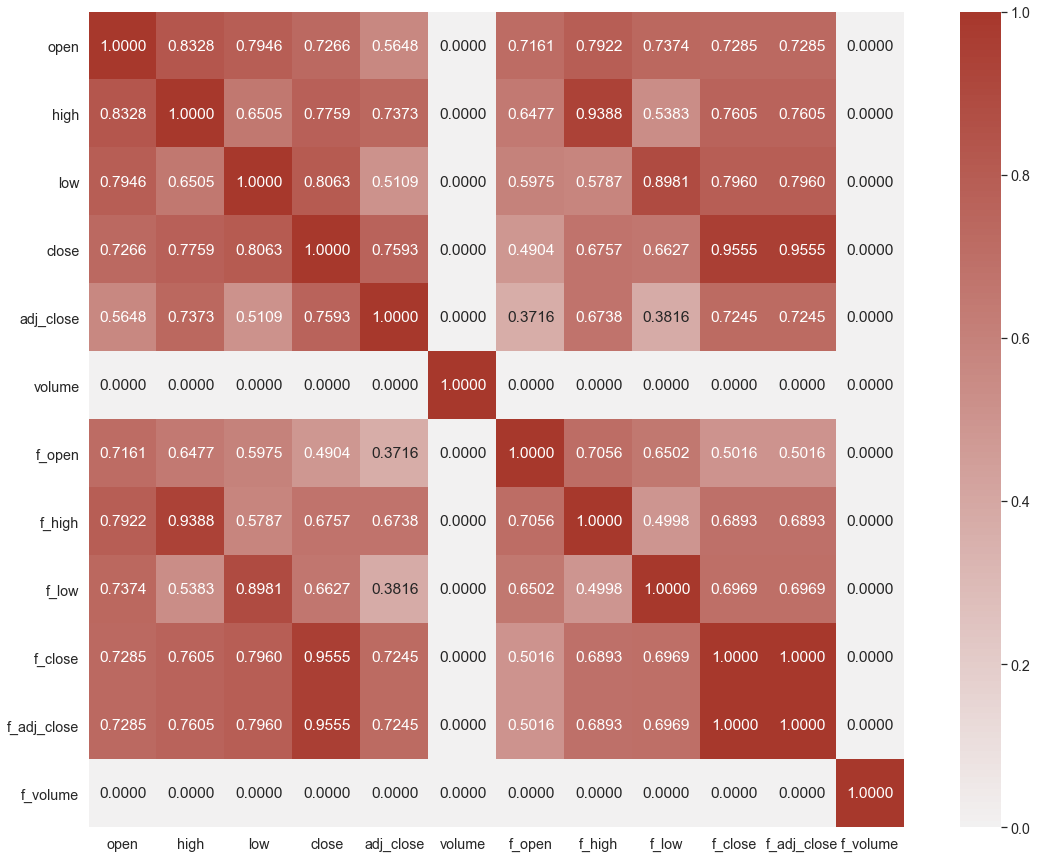

In [50]:
matrix = spy_cat_3Y_df.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix**150, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')

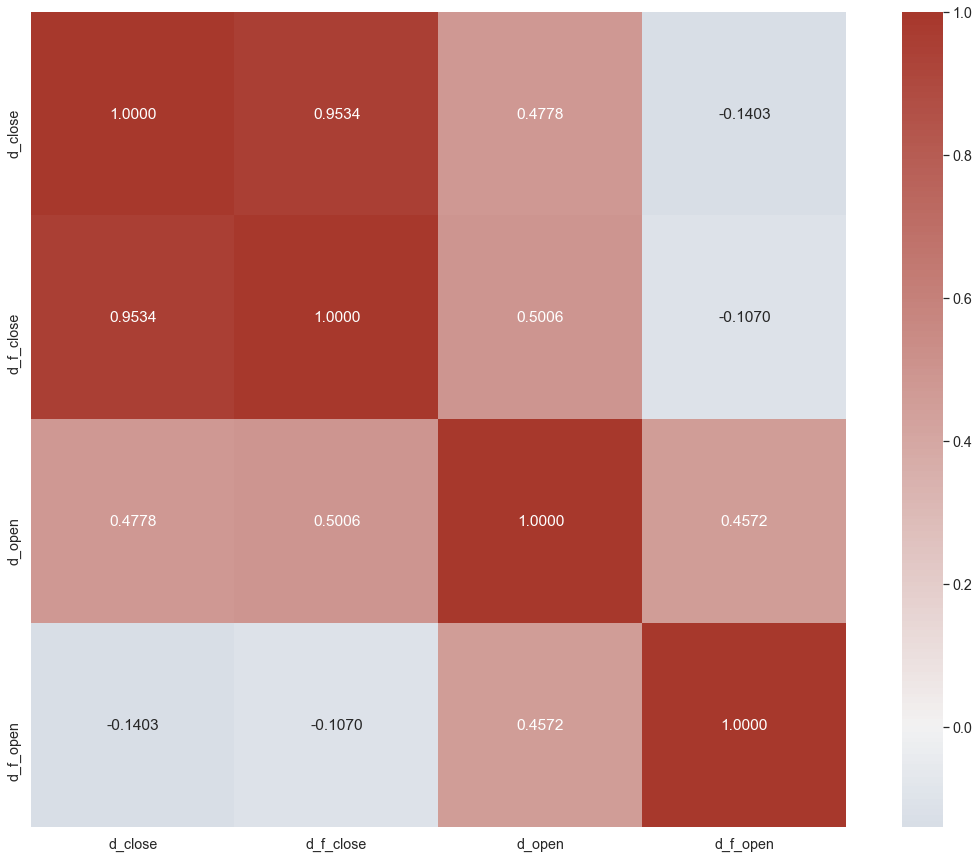

In [51]:
matrix = spy_cat_3Y_df_diff.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')

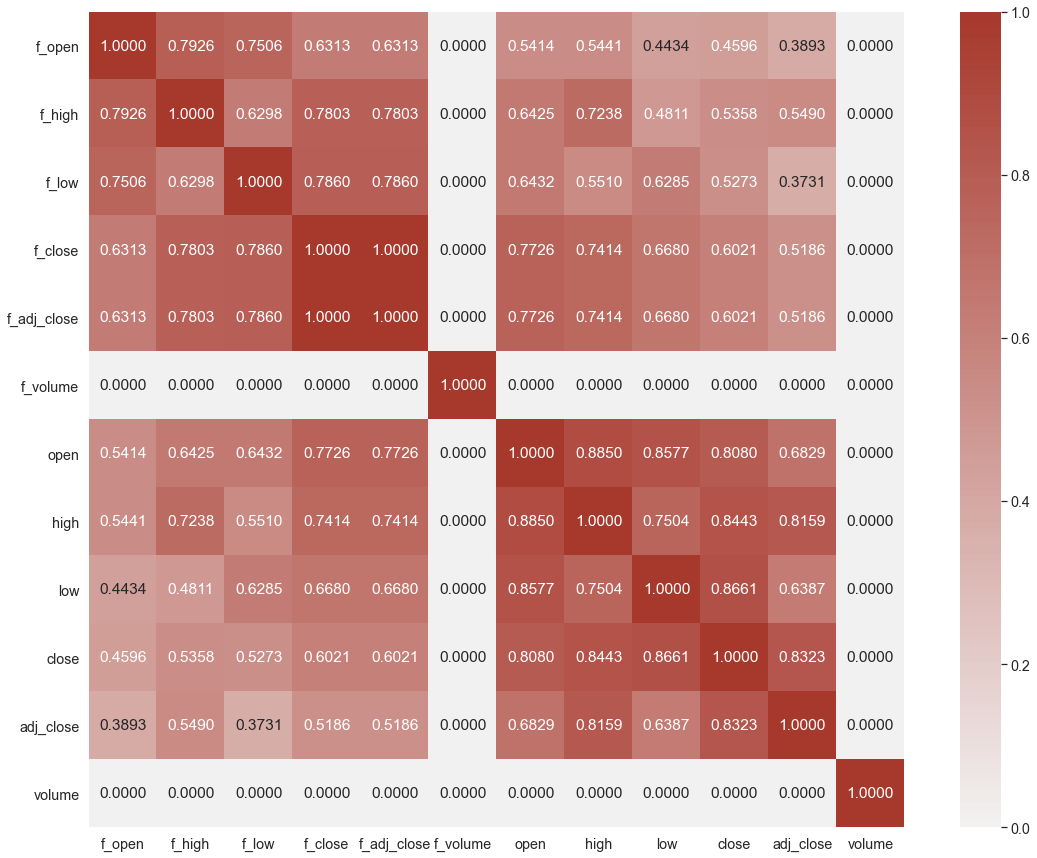

In [52]:
matrix = df_1d_back.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix**100, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')

# Modeling

## pmdarima

### Treasury Exogenous Variables

In [111]:
tsy_all_df_10Y.index

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29',
               '2021-04-30', '2021-05-03', '2021-05-04', '2021-05-05',
               '2021-05-06', '2021-05-07'],
              dtype='datetime64[ns]', name='date', length=7120, freq='C')

In [156]:
pam_tsy_all_10Y.conf_ints;

#### 3Y

In [159]:
pam_tsy_3Y_10Y = Pmdarima_Model(tsy_3Y_df_10Y, 'TSY 10Y Note',
               n=3, periods='years', freq='1 Day', f_seas=252, fit_seas=False, #with_intercept=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, #trend='t', k=4,
               date=True, fourier=False, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


Starting AutoARIMA...
Data set diffs to use: 1


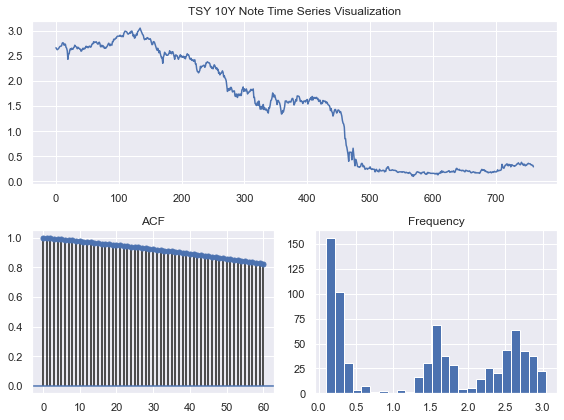

Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2135.476, Time=0.77 sec
First viable model found (-2135.476)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2137.169, Time=0.41 sec
New best model found (-2137.169 < -2135.476)
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2135.581, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2135.534, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2133.114, Time=0.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2133.627, Time=0.87 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 4.573 seconds
Saved best AutoARIMA model as /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/TSY_10Y_Note_3

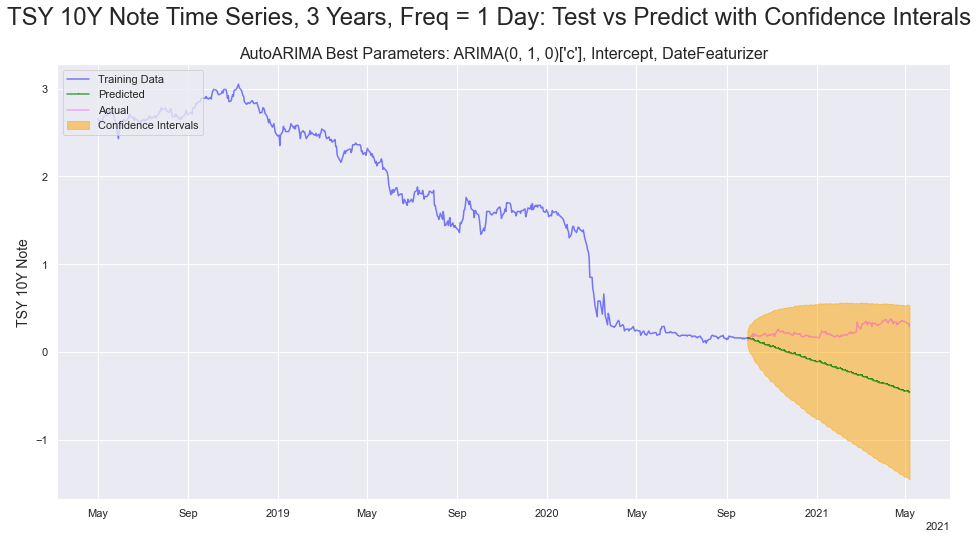

In [160]:
pam_tsy_3Y_10Y_AA_pipe = pam_tsy_3Y_10Y.run_auto_pipeline(show_summary=True, verbose=1, visualize=True)

int

Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 0)['n'], DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 1)['t'], Intercept, Da

________________________________________________________________________

Running step-wise cross-validation on model 1 of 1... 
ARIMA Order(2, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 0, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(2, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=-2799.938 | RMSE=0.018 | RMSE_pc=1.071% | SMAPE=5.643%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 199.
Adding scores to model, updating line 199.

GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(2, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=-2799.938 | RMSE=0.018 | RMSE%=1.071% | SMAPE=5.643%
/Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/TSY_10Y_Note_3Y_1D_GS_best_model.pkl
Model outperforms existing best GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/TSY_10Y_Note_3Y_1D_GS_best_model.pkl, overwriting.


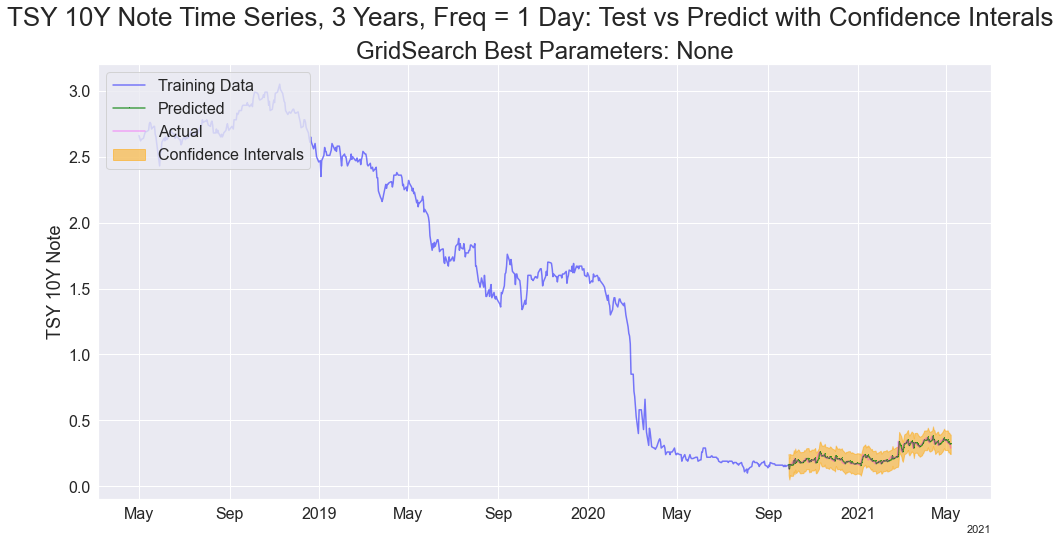

In [346]:
pam_tsy_3Y_10Y_best, scores = pam_tsy_3Y_10Y.run_gridsearch_CV(min_order=0, max_order=3, min_d=0, max_d=0, min_p=0, min_q=0,
                                    with_intercept='auto', f_m=252, k=2, #t_list=['c','n'],
                                    fourier=False, box=False, log=False, debug=False, verbose=1, parallel=False)

In [345]:
pam_tsy_3Y_10Y_best, scores = pam_tsy_3Y_10Y.run_gridsearch_CV(min_order=0, max_order=3, min_d=0, max_d=0, min_p=0, min_q=0,
                                    with_intercept='auto', f_m=252, k=2, #t_list=['c','n'],
                                    fourier=False, box=False, log=False, debug=False, verbose=1, parallel=False)

Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 0)['n'], DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do.Model already scored, skipping.
ARIMA Order(0, 0, 1)['t'], Intercept, Da

AssertionError: Based on parameters given, 0 models built out of 40 in grid, terminating.

NameError: name 'func' is not defined

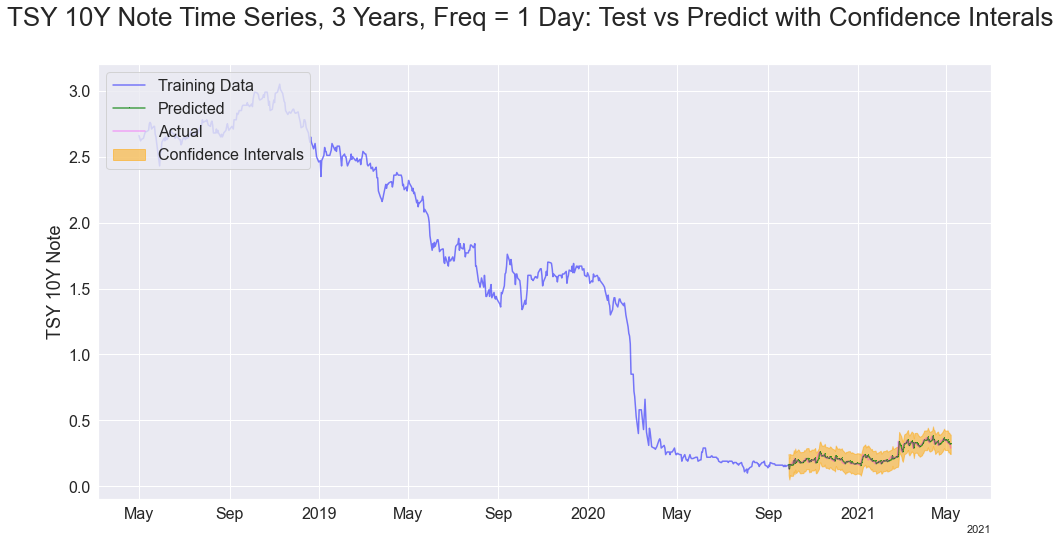

In [330]:
func = 'GS'

conf = ''
ylabel = pam_tsy_3Y_10Y.data_name
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(pam_tsy_3Y_10Y.X_train, pam_tsy_3Y_10Y.y_train, color='blue', alpha=0.5, label='Training Data')
ax.plot(pam_tsy_3Y_10Y.X_test, pam_tsy_3Y_10Y.y_hat, color='green', marker=',', alpha=0.7, label='Predicted')
ax.plot(pam_tsy_3Y_10Y.X_test, pam_tsy_3Y_10Y.y_test, color='magenta', alpha=0.3, label='Actual')

conf = '_Conf'
conf_int = np.asarray(pam_tsy_3Y_10Y.conf_ints)
ax.fill_between(pam_tsy_3Y_10Y.X_test.date,
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.5, color='orange',
         label="Confidence Intervals")
ax.legend(loc='upper left', borderaxespad=0.5, prop={"size":16})
fig.suptitle(f'{ylabel} Time Series, {pam_tsy_3Y_10Y.timeframe}, Freq = {pam_tsy_3Y_10Y.freq}: Test vs Predict with Confidence Interals\n', size=26)
ax.set_ylabel(ylabel, size=18)
ax.set_xlabel(ax.get_xlabel(), size=18)
tick_params = dict(size=4, width=1.5, labelsize=16)
ax.tick_params(axis='y', **tick_params)
ax.tick_params(axis='x', **tick_params)
if func == 'AA':
    ax.set_title(f'AutoARIMA Best Parameters: {pam_tsy_3Y_10Y.AA_best_params}', size=24)
    plt.savefig(f'{TOP}/images/AutoArima/{pam_tsy_3Y_10Y.ts}_{pam_tsy_3Y_10Y.tf}_{pam_tsy_3Y_10Y.f}_Test_vs_Predict{conf}.png')
elif func == 'GS':
    ax.set_title(f'GridSearch Best Parameters: {pam_tsy_3Y_10Y.GS_best_params}', size=24)
    plt.savefig(f'{TOP}/images/GridSearch/{pam_tsy_3Y_10Y.ts}_{pam_tsy_3Y_10Y.tf}_{pam_tsy_3Y_10Y.f}_Test_vs_Predict{conf}.png')
else:
    ax.set_title(f'Parameters: {pam_tsy_3Y_10Y.mod_params}', size=24)
    plt.savefig(f'{TOP}/images/{pam_tsy_3Y_10Y.ts}_{pam_tsy_3Y_10Y.tf}_{pam_tsy_3Y_10Y.f}_Test_vs_Predict{conf}.png')

In [340]:
mod_file = open(pkl_filepath,'rb')
mod_data = pkl.load(mod_file)
mod_file.close()
mod_data[2]

,ARIMA_Order,Diffs,Mod_Order,Trend,Intercept,Date,Fourier,Fourier_m,Fourier_k,BoxCox,Log,Scored,AIC,RMSE,RMSE%,SMAPE,CV_Time
Model,,,,,,,,,,,,,,,,,
0,"(2, 0, 0)",0,2,c,True,True,False,None,None,False,False,True,-2799.9381,0.0185,1.0714,5.6428,68.8024


#### 10Y Note - 10Y

In [72]:
verbose = 1

Successfully created instance of Class Pmdarima_Model.
Starting AutoARIMA...
Data set diffs to use: 1


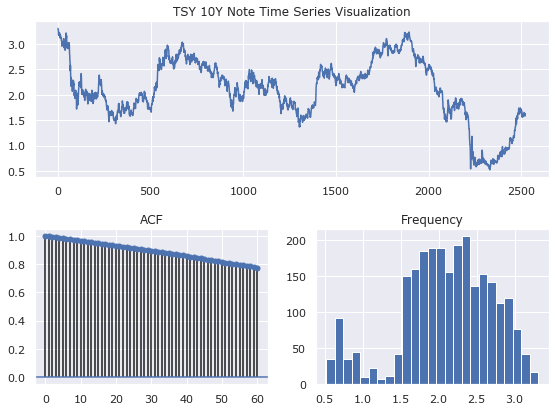

Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6693.024, Time=8.93 sec
First viable model found (-6693.024)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6697.282, Time=1.18 sec
New best model found (-6697.282 < -6693.024)
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6695.412, Time=1.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6695.409, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6699.121, Time=2.55 sec
New best model found (-6699.121 < -6697.282)
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6693.412, Time=1.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 16.867 seconds
Best params:
  ARIMA(0, 1, 0), DateFeaturizer
Test AIC: -6699.121
Test RMSE: 1.296
This is 56.289% of the 

> 

Done.
Test AIC: -8287.710
Test RMSE: 0.050
This is 2.168% of the avg observed value.
Test SMAPE: 3.217%

Saved best AutoARIMA model as /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/TSY_10Y_Note_10Y_1D_AA_best_model.pkl.

Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 0)['n'], DateFeaturizer
Attempting to add new mod

ARIMA Order(1, 1, 1)['n'], DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(2, 1, 0)['n'], DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
Finished building list of 48 models.
Starting 

________________________________________________________________________

Running step-wise cross-validation on model 1 of 48... 
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=4671.923 | RMSE=1.044 | RMSE_pc=45.318% | SMAPE=57.979%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 1.
Adding scores to model, updating line 1.
________________________________________________________________________

Running step-wise cross-validation on model 2 of 48... 
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=4411.362 | RMSE=0.978 | RMSE_pc=42.466% | SMAPE=55.215%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 2.
Adding scores to model, updating line 2.
________________________________________________________________________

Running step-wise cross-validation on model 3 of 48... 
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=4518.972 | RMSE=1.067 | RMSE_pc=46.327% | SMAPE=59.081%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 3.
Adding scores to model, updating line 3.
________________________________________________________________________

Running step-wise cross-validation on model 4 of 48... 
ARIMA Order(0, 0, 0)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['n'], DateFeaturizer]: AIC=4669.954 | RMSE=1.045 | RMSE_pc=45.370% | SMAPE=58.016%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 4.
Adding scores to model, updating line 4.
________________________________________________________________________

Running step-wise cross-validation on model 5 of 48... 
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer]: AIC=1468.593 | RMSE=0.546 | RMSE_pc=23.710% | SMAPE=37.909%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 5.
Adding scores to model, updating line 5.
________________________________________________________________________

Running step-wise cross-validation on model 6 of 48... 
ARIMA Order(0, 0, 1)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['t'], Intercept, DateFeaturizer]: AIC=1278.333 | RMSE=0.509 | RMSE_pc=22.079% | SMAPE=35.560%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 6.
Adding scores to model, updating line 6.
________________________________________________________________________

Running step-wise cross-validation on model 7 of 48... 
ARIMA Order(0, 0, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['ct'], Intercept, DateFeaturizer]: AIC=1527.237 | RMSE=0.580 | RMSE_pc=25.181% | SMAPE=39.863%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 7.
Adding scores to model, updating line 7.
________________________________________________________________________

Running step-wise cross-validation on model 8 of 48... 
ARIMA Order(0, 0, 1)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['n'], DateFeaturizer]: AIC=1466.877 | RMSE=0.549 | RMSE_pc=23.831% | SMAPE=38.026%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 8.
Adding scores to model, updating line 8.
________________________________________________________________________

Running step-wise cross-validation on model 9 of 48... 
ARIMA Order(0, 0, 2)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 2), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 2)['c'], Intercept, DateFeaturizer]: AIC=-1034.220 | RMSE=0.324 | RMSE_pc=14.085% | SMAPE=25.103%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 9.
Adding scores to model, updating line 9.
________________________________________________________________________

Running step-wise cross-validation on model 10 of 48... 
ARIMA Order(0, 0, 2)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 2), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 2)['t'], Intercept, DateFeaturizer]: AIC=-426.450 | RMSE=0.352 | RMSE_pc=15.276% | SMAPE=25.755%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 10.
Adding scores to model, updating line 10.
________________________________________________________________________

Running step-wise cross-validation on model 11 of 48... 
ARIMA Order(0, 0, 2)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 2), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 2)['ct'], Intercept, DateFeaturizer]: AIC=-276.325 | RMSE=0.401 | RMSE_pc=17.401% | SMAPE=30.092%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 11.
Adding scores to model, updating line 11.
________________________________________________________________________

Running step-wise cross-validation on model 12 of 48... 
ARIMA Order(0, 0, 2)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 2), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 2)['n'], DateFeaturizer]: AIC=-1035.463 | RMSE=0.328 | RMSE_pc=14.244% | SMAPE=25.333%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 12.
Adding scores to model, updating line 12.
________________________________________________________________________

Running step-wise cross-validation on model 13 of 48... 
ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=-8275.996 | RMSE=0.050 | RMSE_pc=2.187% | SMAPE=3.280%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 13.
Adding scores to model, updating line 13.
________________________________________________________________________

Running step-wise cross-validation on model 14 of 48... 
ARIMA Order(1, 0, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=-8250.779 | RMSE=0.051 | RMSE_pc=2.193% | SMAPE=3.319%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 14.
Adding scores to model, updating line 14.
________________________________________________________________________

Running step-wise cross-validation on model 15 of 48... 
ARIMA Order(1, 0, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=-8234.333 | RMSE=0.051 | RMSE_pc=2.206% | SMAPE=3.337%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 15.
Adding scores to model, updating line 15.
________________________________________________________________________

Running step-wise cross-validation on model 16 of 48... 
ARIMA Order(1, 0, 0)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['n'], DateFeaturizer]: AIC=-8276.403 | RMSE=0.050 | RMSE_pc=2.189% | SMAPE=3.290%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 16.
Adding scores to model, updating line 16.
________________________________________________________________________

Running step-wise cross-validation on model 17 of 48... 
ARIMA Order(1, 0, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 1)['c'], Intercept, DateFeaturizer]: AIC=-8274.859 | RMSE=0.050 | RMSE_pc=2.187% | SMAPE=3.277%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 17.
Adding scores to model, updating line 17.
________________________________________________________________________

Running step-wise cross-validation on model 18 of 48... 
ARIMA Order(1, 0, 1)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 1)['t'], Intercept, DateFeaturizer]: AIC=-8249.224 | RMSE=0.050 | RMSE_pc=2.193% | SMAPE=3.316%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 18.
Adding scores to model, updating line 18.
________________________________________________________________________

Running step-wise cross-validation on model 19 of 48... 
ARIMA Order(1, 0, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 1)['ct'], Intercept, DateFeaturizer]: AIC=-8232.935 | RMSE=0.051 | RMSE_pc=2.205% | SMAPE=3.335%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 19.
Adding scores to model, updating line 19.
________________________________________________________________________

Running step-wise cross-validation on model 20 of 48... 
ARIMA Order(1, 0, 1)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 1), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 1)['n'], DateFeaturizer]: AIC=-8275.505 | RMSE=0.050 | RMSE_pc=2.188% | SMAPE=3.286%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 20.
Adding scores to model, updating line 20.
________________________________________________________________________

Running step-wise cross-validation on model 21 of 48... 
ARIMA Order(2, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 0, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(2, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=-8274.128 | RMSE=0.050 | RMSE_pc=2.187% | SMAPE=3.278%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 21.
Adding scores to model, updating line 21.
________________________________________________________________________

Running step-wise cross-validation on model 22 of 48... 
ARIMA Order(2, 0, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 0, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(2, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=-8249.021 | RMSE=0.051 | RMSE_pc=2.193% | SMAPE=3.318%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 22.
Adding scores to model, updating line 22.
________________________________________________________________________

Running step-wise cross-validation on model 23 of 48... 
ARIMA Order(2, 0, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 0, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(2, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=-8232.702 | RMSE=0.051 | RMSE_pc=2.206% | SMAPE=3.336%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 23.
Adding scores to model, updating line 23.
________________________________________________________________________

Running step-wise cross-validation on model 24 of 48... 
ARIMA Order(2, 0, 0)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 0, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(2, 0, 0)['n'], DateFeaturizer]: AIC=-8274.575 | RMSE=0.050 | RMSE_pc=2.189% | SMAPE=3.289%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 24.
Adding scores to model, updating line 24.
________________________________________________________________________

Running step-wise cross-validation on model 25 of 48... 
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=-8286.225 | RMSE=0.050 | RMSE_pc=2.168% | SMAPE=3.223%
Updated class attributes for GridSearch performance.
First viable model found, RMSE=0.050
Saved best GridSearchCV model as /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/TSY_10Y_Note_10Y_1D_GS_best_model.pkl.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 25.
Adding scores to model, updating line 25.
________________________________________________________________________

Running step-wise cross-validation on model 26 of 48... 
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on '

> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=-8282.102 | RMSE=0.050 | RMSE_pc=2.170% | SMAPE=3.225%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 26.
Adding scores to model, updating line 26.
________________________________________________________________________

Running step-wise cross-validation on model 27 of 48... 
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=-8279.693 | RMSE=0.050 | RMSE_pc=2.172% | SMAPE=3.231%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 27.
Adding scores to model, updating line 27.
________________________________________________________________________

Running step-wise cross-validation on model 28 of 48... 
ARIMA Order(0, 1, 0)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['n'], DateFeaturizer]: AIC=-8287.710 | RMSE=0.050 | RMSE_pc=2.168% | SMAPE=3.217%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 28.
Adding scores to model, updating line 28.
________________________________________________________________________

Running step-wise cross-validation on model 29 of 48... 
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer]: AIC=-8284.118 | RMSE=0.050 | RMSE_pc=2.169% | SMAPE=3.223%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 29.
Adding scores to model, updating line 29.
________________________________________________________________________

Running step-wise cross-validation on model 30 of 48... 
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer]: AIC=-8279.834 | RMSE=0.050 | RMSE_pc=2.170% | SMAPE=3.224%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 30.
Adding scores to model, updating line 30.
________________________________________________________________________

Running step-wise cross-validation on model 31 of 48... 
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=-8277.420 | RMSE=0.050 | RMSE_pc=2.173% | SMAPE=3.230%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 31.
Adding scores to model, updating line 31.
________________________________________________________________________

Running step-wise cross-validation on model 32 of 48... 
ARIMA Order(0, 1, 1)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['n'], DateFeaturizer]: AIC=-8285.598 | RMSE=0.050 | RMSE_pc=2.169% | SMAPE=3.217%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 32.
Adding scores to model, updating line 32.
________________________________________________________________________

Running step-wise cross-validation on model 33 of 48... 
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer]: AIC=-8282.449 | RMSE=0.050 | RMSE_pc=2.169% | SMAPE=3.223%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 33.
Adding scores to model, updating line 33.
________________________________________________________________________

Running step-wise cross-validation on model 34 of 48... 
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer]: AIC=-8277.970 | RMSE=0.050 | RMSE_pc=2.170% | SMAPE=3.223%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 34.
Adding scores to model, updating line 34.
________________________________________________________________________

Running step-wise cross-validation on model 35 of 48... 
ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer]: AIC=-8275.568 | RMSE=0.050 | RMSE_pc=2.173% | SMAPE=3.229%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 35.
Adding scores to model, updating line 35.
________________________________________________________________________

Running step-wise cross-validation on model 36 of 48... 
ARIMA Order(0, 1, 2)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 2)['n'], DateFeaturizer]: AIC=-8283.779 | RMSE=0.050 | RMSE_pc=2.169% | SMAPE=3.217%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 36.
Adding scores to model, updating line 36.
________________________________________________________________________

Running step-wise cross-validation on model 37 of 48... 
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=-8284.165 | RMSE=0.050 | RMSE_pc=2.169% | SMAPE=3.223%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 37.
Adding scores to model, updating line 37.
________________________________________________________________________

Running step-wise cross-validation on model 38 of 48... 
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=-8279.864 | RMSE=0.050 | RMSE_pc=2.170% | SMAPE=3.224%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 38.
Adding scores to model, updating line 38.
________________________________________________________________________

Running step-wise cross-validation on model 39 of 48... 
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=-8277.389 | RMSE=0.050 | RMSE_pc=2.173% | SMAPE=3.230%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 39.
Adding scores to model, updating line 39.
________________________________________________________________________

Running step-wise cross-validation on model 40 of 48... 
ARIMA Order(1, 1, 0)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['n'], DateFeaturizer]: AIC=-8285.664 | RMSE=0.050 | RMSE_pc=2.169% | SMAPE=3.217%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 40.
Adding scores to model, updating line 40.
________________________________________________________________________

Running step-wise cross-validation on model 41 of 48... 
ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer]: AIC=-8282.220 | RMSE=0.050 | RMSE_pc=2.169% | SMAPE=3.223%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 41.
Adding scores to model, updating line 41.
________________________________________________________________________

Running step-wise cross-validation on model 42 of 48... 
ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer]: AIC=-8277.844 | RMSE=0.050 | RMSE_pc=2.170% | SMAPE=3.224%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 42.
Adding scores to model, updating line 42.
________________________________________________________________________

Running step-wise cross-validation on model 43 of 48... 
ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=-8275.433 | RMSE=0.050 | RMSE_pc=2.173% | SMAPE=3.230%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 43.
Adding scores to model, updating line 43.
________________________________________________________________________

Running step-wise cross-validation on model 44 of 48... 
ARIMA Order(1, 1, 1)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Iteratively making predictions on 'TSY 10Y Note' Time Series and updating model, beginning with first index of y_test ...


KeyboardInterrupt: 

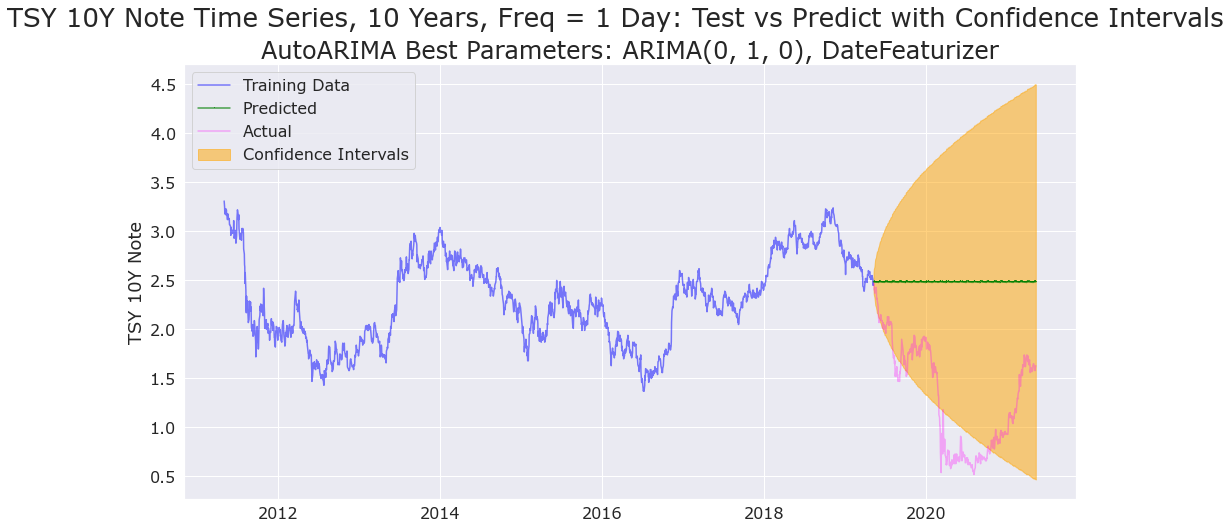

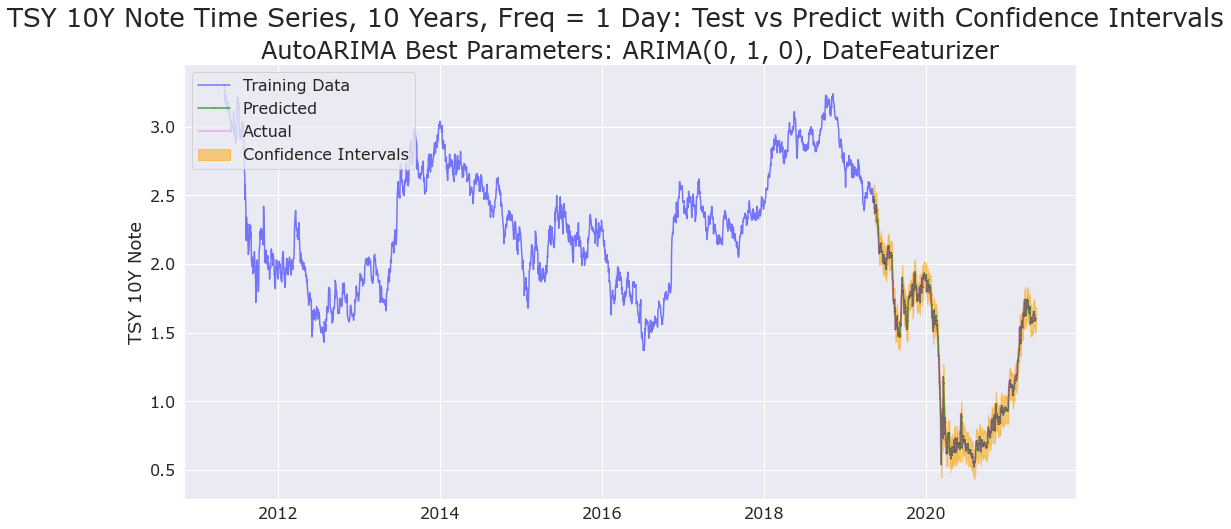

In [73]:
pam_tsy_10Y_10Y = Pmdarima_Model(tsy_10Y_df_10Y, 'TSY 10Y Note',
                   n=10, periods='years', freq='1 Day', f_seas=252, fit_seas=False, #with_intercept=False,
                   estimate_diffs=True, train_size=80, impute=False, verbose=1, #trend='t', k=4,
                   date=True, fourier=False, box=False, log=False)
pam_tsy_10_10Y_AA_pipe = pam_tsy_10Y_10Y.run_auto_pipeline(show_summary=True, verbose=1, visualize=True)
AA_CV_scores = pam_tsy_10Y_10Y.run_stepwise_CV(dynamic=False, verbose=1, visualize=True)
pam_tsy_10Y_10Y_best, scores = pam_tsy_10Y_10Y.run_gridsearch_CV(min_order=0, max_order=2, min_d=0, max_d=1, min_p=0, min_q=0,
                   with_intercept='auto', f_m=252, k=2, #t_list=['c','n'],
                   fourier=False, box=False, log=False, debug=False, verbose=1, parallel=False)

#### All Years

In [ ]:
pam_tsy_all_10Y = Pmdarima_Model(tsy_all_df_10Y, 'TSY 10Y Note', order=(0,1,0), trend='t',
               n='All', periods='years', freq='1 Day', f_seas=252, fit_seas=False, #with_intercept=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, #trend='t', k=4,
               date=True, fourier=True, box=False, log=False)

Explict model pipe passed: 
       ARIMA_Order  Diffs  Mod_Order Trend Intercept  Date  Fourier  Fourier_m  \
Model                                                                           
0       (0, 1, 0)      1          0     t      auto  True     True        252   

       Fourier_k  BoxCox    Log  Scored   AIC  RMSE RMSE% SMAPE CV_Time  
Model                                                                    
0              4   False  False   False  None  None  None  None    None  
Pipeline: 
 Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])
Starting step-wise cross-validation on adhoc model....
Iteratively making predictions on TSY 10Y Note Time Series and updating model, beginning with first index of y_test ...


> 
>_

Done.
Test AIC: -20484.799
Test RMSE: 0.043
This is 0.962% of the avg observed value.
Test SMAPE: 2.015%

Attempting to add a new score to file... Model not already present in file. Appending model scores to file. int64 float64 



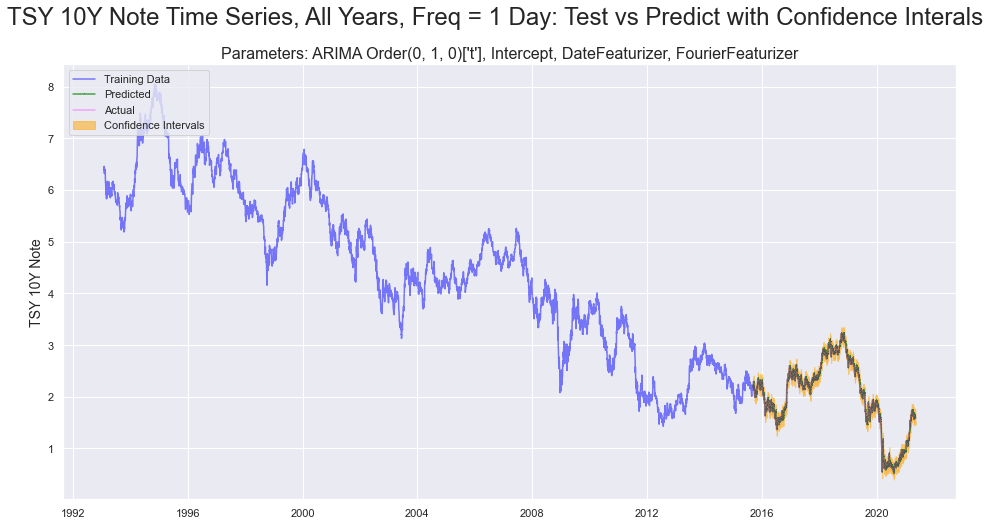

In [242]:
AIC, RMSE, RMSE_pc, SMAPE = pam_tsy_all_10Y.run_stepwise_CV(func='adhoc', dynamic=False, verbose=1, visualize=True)

Starting AutoARIMA...
Data set diffs to use: 1


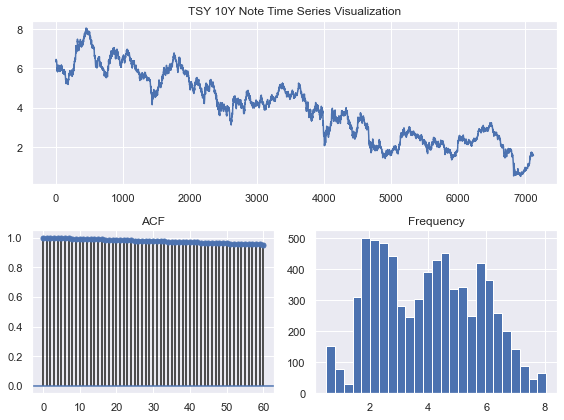

Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-15830.010, Time=30.68 sec
First viable model found (-15830.010)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15829.618, Time=10.97 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15829.105, Time=12.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15829.211, Time=11.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15830.769, Time=15.14 sec
New best model found (-15830.769 < -15830.010)
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15828.644, Time=19.86 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 100.756 seconds
Saved best AutoARIMA model as /Users/wax/Documents/Class

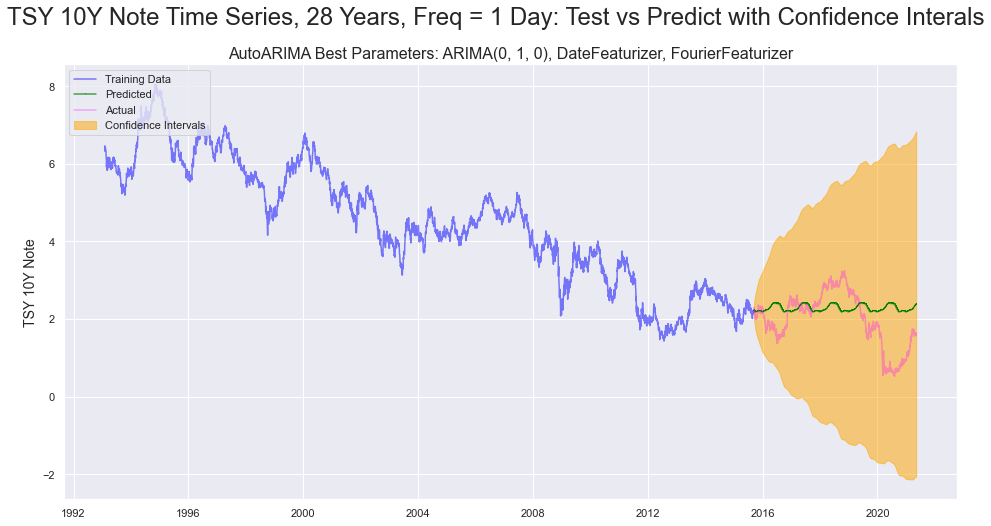

In [113]:
pam_tsy_all_10Y_AA_pipe = pam_tsy_all_10Y.run_auto_pipeline(show_summary=True, verbose=1, visualize=True)

ARIMA(0, 1, 0), DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on TSY 10Y Note Time Series and updating model, beginning with first index of y_test ...


>_
Done.
Test AIC: -20523.139
Test RMSE: 0.043
This is 0.962% of the avg observed value.
Test SMAPE: 2.014%




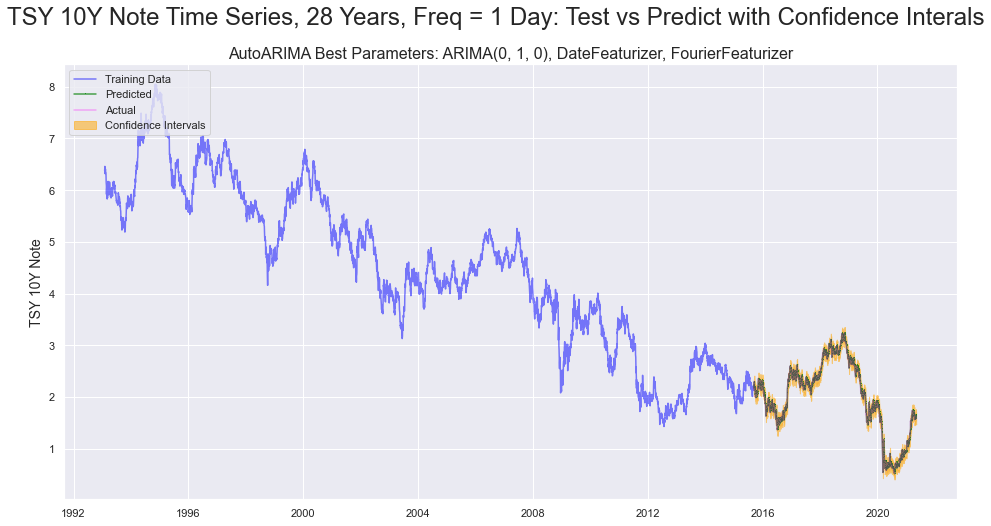

In [119]:
AIC, RMSE, RMSE_pc, SMAPE = pam_tsy_all_10Y.run_stepwise_CV(dynamic=False, verbose=1, visualize=True)

In [157]:
pam_tsy_3Y_10Y_best, scores = pam_tsy_all_10Y.run_gridsearch_CV(min_order=0, max_order=0, min_d=0, max_d=0, min_p=0, min_q=0,
                                    t_list=['n', 'c', 't', 'ct'], with_intercept='auto', f_m=252, # k=2,
                                    fourier=False, box=False, log=False, debug=False, verbose=0, parallel=False)

Starting GridSearchCV...
Running normally.


________________________________________________________________________

Starting step-wise cross-validation...


> 


KeyboardInterrupt: 

### Effective Fed Funds Rate

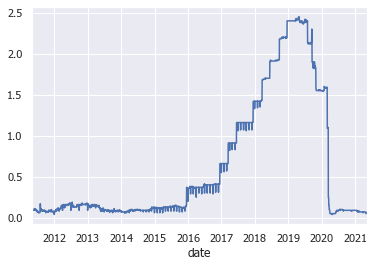

In [175]:
fed_10Y_df.plot()

Successfully created instance of Class Pmdarima_Model.
Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 1, 0)['n'], DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model

________________________________________________________________________

Running step-wise cross-validation on model 1 of 12... 
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Effective Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10482.022 | RMSE: 0.052 | RMSE%=8.997% | SMAPE 4.536%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer]: AIC=-10482.022 | RMSE=0.052 | RMSE_pc=8.997% | SMAPE=4.536%
Updated class attributes for GridSearch performance.
First viable model found, RMSE=0.052
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/Fed_Funds_Effective_Rate_10Y_1D_GS_best_model.pkl.
Model outperforms existing best GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/Fed_Funds_Effective_Rate_10Y_1D_GS_best_model.pkl, overwriting.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 36.
Adding scores to model, updating line 36.
________________________________________________________________________

Running step-wise cross-validation on model 2 of 12... 
A

> 

Done.
AIC: -9777.191 | RMSE: 0.052 | RMSE%=9.052% | SMAPE 5.032%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer]: AIC=-9777.191 | RMSE=0.052 | RMSE_pc=9.052% | SMAPE=5.032%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 37.
Adding scores to model, updating line 37.
________________________________________________________________________

Running step-wise cross-validation on model 3 of 12... 
ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Effective Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -9765.990 | RMSE: 0.052 | RMSE%=9.066% | SMAPE 5.016%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer]: AIC=-9765.990 | RMSE=0.052 | RMSE_pc=9.066% | SMAPE=5.016%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 38.
Adding scores to model, updating line 38.
________________________________________________________________________

Running step-wise cross-validation on model 4 of 12... 
ARIMA Order(0, 1, 2)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Effective Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10484.342 | RMSE: 0.051 | RMSE%=8.975% | SMAPE 4.540%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 2)['n'], DateFeaturizer]: AIC=-10484.342 | RMSE=0.051 | RMSE_pc=8.975% | SMAPE=4.540%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=0.051
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/Fed_Funds_Effective_Rate_10Y_1D_GS_best_model.pkl.
Model outperforms existing best GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/Fed_Funds_Effective_Rate_10Y_1D_GS_best_model.pkl, overwriting.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 39.
Adding scores to model, updating line 39.
________________________________________________________________________

Running step-wise cross-validation on model 5 of 12... 
ARIMA Order(1, 

> 

Done.
AIC: -10481.703 | RMSE: 0.052 | RMSE%=8.997% | SMAPE 4.543%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer]: AIC=-10481.703 | RMSE=0.052 | RMSE_pc=8.997% | SMAPE=4.543%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 40.
Adding scores to model, updating line 40.
________________________________________________________________________

Running step-wise cross-validation on model 6 of 12... 
ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Effective Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -9771.581 | RMSE: 0.052 | RMSE%=9.051% | SMAPE 4.967%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer]: AIC=-9771.581 | RMSE=0.052 | RMSE_pc=9.051% | SMAPE=4.967%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 41.
Adding scores to model, updating line 41.
________________________________________________________________________

Running step-wise cross-validation on model 7 of 12... 
ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Effective Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -9759.715 | RMSE: 0.052 | RMSE%=9.068% | SMAPE 5.045%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=-9759.715 | RMSE=0.052 | RMSE_pc=9.068% | SMAPE=5.045%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 42.
Adding scores to model, updating line 42.
________________________________________________________________________

Running step-wise cross-validation on model 8 of 12... 
ARIMA Order(1, 1, 1)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Effective Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10484.993 | RMSE: 0.052 | RMSE%=8.988% | SMAPE 4.546%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 1)['n'], DateFeaturizer]: AIC=-10484.993 | RMSE=0.052 | RMSE_pc=8.988% | SMAPE=4.546%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 43.
Adding scores to model, updating line 43.
________________________________________________________________________

Running step-wise cross-validation on model 9 of 12... 
ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Effective Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10479.514 | RMSE: 0.052 | RMSE%=9.022% | SMAPE 4.529%
Successfully completed step-wise CV on model.
Model[ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=-10479.514 | RMSE=0.052 | RMSE_pc=9.022% | SMAPE=4.529%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 44.
Adding scores to model, updating line 44.
________________________________________________________________________

Running step-wise cross-validation on model 10 of 12... 
ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Effective Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -9772.116 | RMSE: 0.052 | RMSE%=9.048% | SMAPE 5.018%
Successfully completed step-wise CV on model.
Model[ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=-9772.116 | RMSE=0.052 | RMSE_pc=9.048% | SMAPE=5.018%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 45.
Adding scores to model, updating line 45.
________________________________________________________________________

Running step-wise cross-validation on model 11 of 12... 
ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Effective Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -9762.374 | RMSE: 0.052 | RMSE%=9.061% | SMAPE 5.139%
Successfully completed step-wise CV on model.
Model[ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=-9762.374 | RMSE=0.052 | RMSE_pc=9.061% | SMAPE=5.139%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 46.
Adding scores to model, updating line 46.
________________________________________________________________________

Running step-wise cross-validation on model 12 of 12... 
ARIMA Order(2, 1, 0)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Effective Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10483.269 | RMSE: 0.052 | RMSE%=9.006% | SMAPE 4.528%
Successfully completed step-wise CV on model.
Model[ARIMA Order(2, 1, 0)['n'], DateFeaturizer]: AIC=-10483.269 | RMSE=0.052 | RMSE_pc=9.006% | SMAPE=4.528%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 47.
Adding scores to model, updating line 47.

GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(0, 1, 2)['n'], DateFeaturizer]: AIC=-10484.342 | RMSE=0.051 | RMSE%=8.975% | SMAPE=4.540%
Model[ARIMA Order(1, 1, 1)['n'], DateFeaturizer]: AIC=-10484.993 | RMSE=0.052 | RMSE%=8.988% | SMAPE=4.546%
Model[ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer]: AIC=-10482.022 | RMSE=0.052 | RMSE%=8.997% | SMAPE=4.536%
Model[ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer]: AIC=-10481.703 | RMSE=0.052 | RMSE%=8.997% | SMAPE=4.543%
Model[ARIMA Order(2, 1, 0)['n'], DateFeaturizer]: AIC=-10483.269 | RMSE=0.052 | RMSE%=9.006% | SMAPE=4.528%
Model[ARIMA Order(2, 1, 

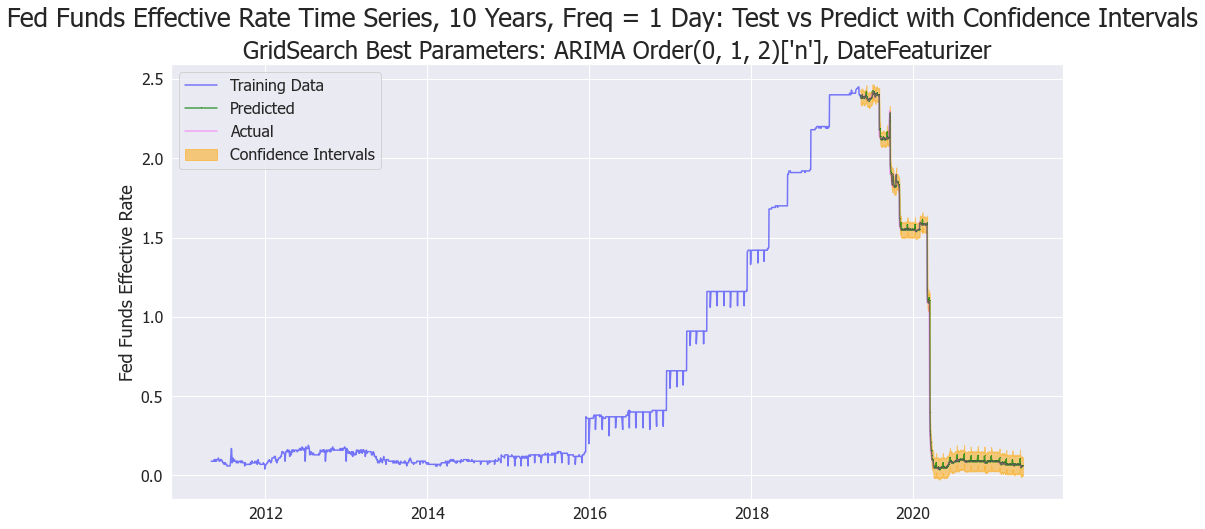

In [176]:
pam_fed_funds_10Y = Pmdarima_Model(fed_10Y_df, 'Fed Funds Effective Rate', order=(0,1,0), trend='t',
               n=10, periods='years', freq='1 Day', f_seas=252, fit_seas=False, #with_intercept=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, #trend='t', k=4,
               date=True, fourier=False, box=False, log=False)
pam_fed_funds_10Y_best, scores = pam_fed_funds_10Y.run_gridsearch_CV(min_order=0, max_order=2, min_d=1, max_d=1, min_p=0, min_q=0,
                                    t_list=['n', 'c', 't', 'ct'], with_intercept='auto', #f_m=252, k=2,
                                    fourier=False, box=False, log=False, debug=True, verbose=1, parallel=False)

Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 0)['n'], DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 1)['t'], Intercept, Da

________________________________________________________________________

Running step-wise cross-validation on model 1 of 12... 
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10462.836 | RMSE: 0.051 | RMSE%=8.891% | SMAPE 4.509%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=-10462.836 | RMSE=0.051 | RMSE_pc=8.891% | SMAPE=4.509%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 24.
Adding scores to model, updating line 24.
________________________________________________________________________

Running step-wise cross-validation on model 2 of 12... 
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -9869.939 | RMSE: 0.051 | RMSE%=8.913% | SMAPE 4.631%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=-9869.939 | RMSE=0.051 | RMSE_pc=8.913% | SMAPE=4.631%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 25.
Adding scores to model, updating line 25.
________________________________________________________________________

Running step-wise cross-validation on model 3 of 12... 
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -9863.837 | RMSE: 0.051 | RMSE%=8.922% | SMAPE 4.753%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=-9863.837 | RMSE=0.051 | RMSE_pc=8.922% | SMAPE=4.753%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 26.
Adding scores to model, updating line 26.
________________________________________________________________________

Running step-wise cross-validation on model 4 of 12... 
ARIMA Order(0, 1, 0)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10464.833 | RMSE: 0.051 | RMSE%=8.880% | SMAPE 4.513%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['n'], DateFeaturizer]: AIC=-10464.833 | RMSE=0.051 | RMSE_pc=8.880% | SMAPE=4.513%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 27.
Adding scores to model, updating line 27.
________________________________________________________________________

Running step-wise cross-validation on model 5 of 12... 
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10469.276 | RMSE: 0.052 | RMSE%=9.021% | SMAPE 4.497%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer]: AIC=-10469.276 | RMSE=0.052 | RMSE_pc=9.021% | SMAPE=4.497%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 28.
Adding scores to model, updating line 28.
________________________________________________________________________

Running step-wise cross-validation on model 6 of 12... 
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -9769.380 | RMSE: 0.052 | RMSE%=9.074% | SMAPE 4.994%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer]: AIC=-9769.380 | RMSE=0.052 | RMSE_pc=9.074% | SMAPE=4.994%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 29.
Adding scores to model, updating line 29.
________________________________________________________________________

Running step-wise cross-validation on model 7 of 12... 
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -9758.771 | RMSE: 0.052 | RMSE%=9.088% | SMAPE 4.975%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=-9758.771 | RMSE=0.052 | RMSE_pc=9.088% | SMAPE=4.975%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 30.
Adding scores to model, updating line 30.
________________________________________________________________________

Running step-wise cross-validation on model 8 of 12... 
ARIMA Order(0, 1, 1)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10474.918 | RMSE: 0.052 | RMSE%=9.028% | SMAPE 4.512%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['n'], DateFeaturizer]: AIC=-10474.918 | RMSE=0.052 | RMSE_pc=9.028% | SMAPE=4.512%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 31.
Adding scores to model, updating line 31.
________________________________________________________________________

Running step-wise cross-validation on model 9 of 12... 
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10472.711 | RMSE: 0.052 | RMSE%=9.037% | SMAPE 4.497%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=-10472.711 | RMSE=0.052 | RMSE_pc=9.037% | SMAPE=4.497%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 32.
Adding scores to model, updating line 32.
________________________________________________________________________

Running step-wise cross-validation on model 10 of 12... 
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -9777.635 | RMSE: 0.052 | RMSE%=9.055% | SMAPE 4.943%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=-9777.635 | RMSE=0.052 | RMSE_pc=9.055% | SMAPE=4.943%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 33.
Adding scores to model, updating line 33.
________________________________________________________________________

Running step-wise cross-validation on model 11 of 12... 
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -9769.221 | RMSE: 0.052 | RMSE%=9.067% | SMAPE 4.954%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=-9769.221 | RMSE=0.052 | RMSE_pc=9.067% | SMAPE=4.954%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 34.
Adding scores to model, updating line 34.
________________________________________________________________________

Running step-wise cross-validation on model 12 of 12... 
ARIMA Order(1, 1, 0)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10474.854 | RMSE: 0.052 | RMSE%=9.014% | SMAPE 4.498%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['n'], DateFeaturizer]: AIC=-10474.854 | RMSE=0.052 | RMSE_pc=9.014% | SMAPE=4.498%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 35.
Adding scores to model, updating line 35.

GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(0, 1, 0)['n'], DateFeaturizer]: AIC=-10464.833 | RMSE=0.051 | RMSE%=8.880% | SMAPE=4.513%
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=-10462.836 | RMSE=0.051 | RMSE%=8.891% | SMAPE=4.509%
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=-9869.939 | RMSE=0.051 | RMSE%=8.913% | SMAPE=4.631%
Model[ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=-9863.837 | RMSE=0.051 | RMSE%=8.922% | SMAPE=4.753%
Model[ARIMA Order(1, 1, 0)['n'], DateFeaturizer]: AIC=-10474.854 | RMSE=0.052 | RMSE%=9.014% | SMAPE=4.498%
Model[ARIMA Or

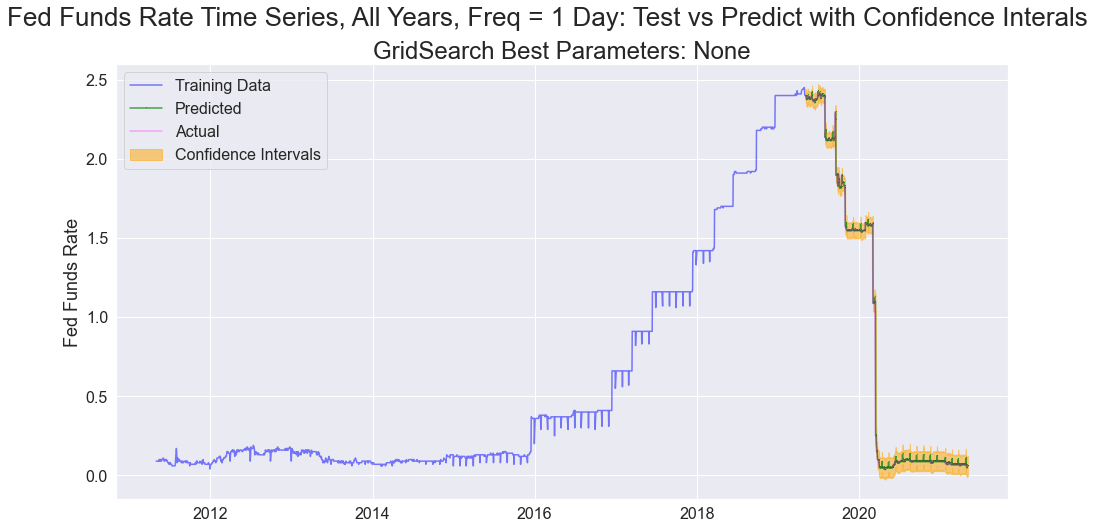

In [365]:
pam_fed_funds_10Y_best, scores = pam_fed_funds_10Y.run_gridsearch_CV(min_order=0, max_order=1, min_d=0, max_d=1, min_p=0, min_q=0,
                                    t_list=['n', 'c', 't', 'ct'], with_intercept='auto', #f_m=252, k=2,
                                    fourier=False, box=False, log=False, debug=True, verbose=1, parallel=False)

### Fed Funds Target Rate - Upper Limit

Successfully created instance of Class Pmdarima_Model.
Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 0)['n'], DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model to test grid.
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model found in file. Already scored. Nothing to do. Not adding model

________________________________________________________________________

Running step-wise cross-validation on model 1 of 1... 
ARIMA Order(1, 0, 0)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making predictions on 'Fed Funds Target Rate' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: -10827.330 | RMSE: 0.053 | RMSE%=7.710% | SMAPE 0.655%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['n'], DateFeaturizer]: AIC=-10827.330 | RMSE=0.053 | RMSE_pc=7.710% | SMAPE=0.655%
Updated class attributes for GridSearch performance.
First viable model found, RMSE=0.053
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/Fed_Funds_Target_Rate_10Y_1D_GS_best_model.pkl.
Model outperforms existing best GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/Fed_Funds_Target_Rate_10Y_1D_GS_best_model.pkl, overwriting.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 31.
Adding scores to model, updating line 31.

GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(1, 0, 0)['n'], DateFeaturizer]: AIC=-10827.330 | RMSE=0.053 | RMSE%=7.710% 

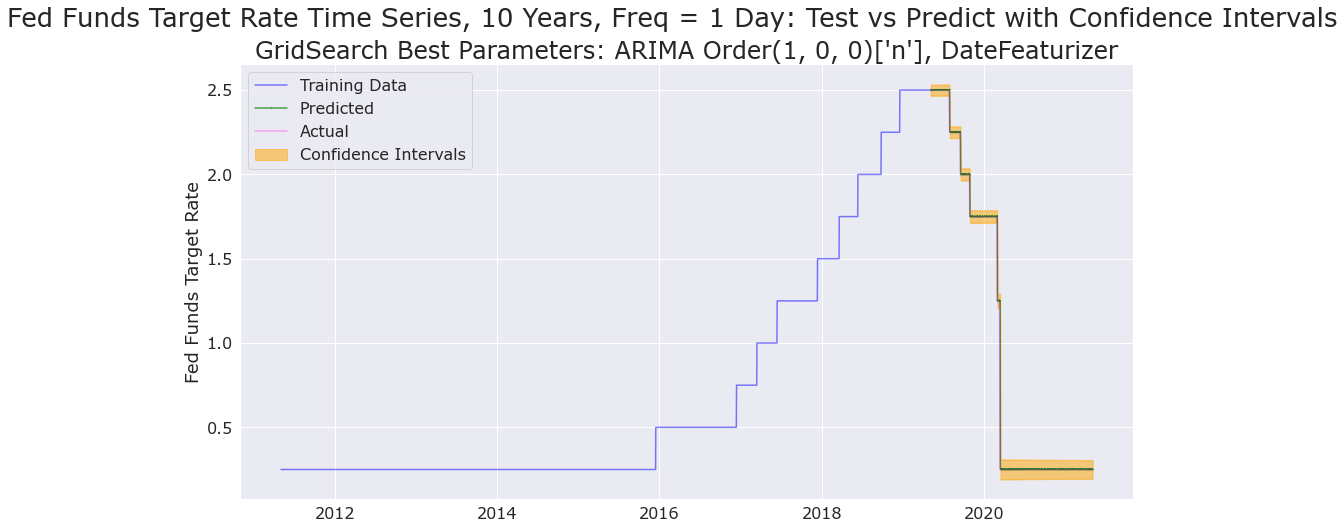

In [62]:
pam_fed_funds_target_10Y = Pmdarima_Model(fed_t_10Y_df, 'Fed Funds Target Rate', order=(0,1,0), trend='t',
               n=10, periods='years', freq='1 Day', f_seas=252, fit_seas=False, #with_intercept=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, #trend='t', k=4,
               date=True, fourier=False, box=False, log=False)
pam_fed_funds_target_10Y_best, scores = pam_fed_funds_target_10Y.run_gridsearch_CV(min_order=0, max_order=1, min_d=0, max_d=1, min_p=0, min_q=0,
                                    t_list=['n', 'c', 't', 'ct'], with_intercept='auto', #f_m=252, k=2,
                                    date=True, fourier=False, box=False, log=False, debug=True, verbose=1, parallel=False)

## TBATS

In [40]:
if __name__ == '__main__':
    tb = tbats.TBATS(seasonal_periods=(3*30.436875, 365.25))
    tb

In [75]:
# X_train, X_test, y_train, y_test = train_test_split(spy_df_3Y.close, test_size = .20, random_state = 729)
train, test = train_test_split_data(spy_df_10Y.close, train_size = 80)
train, test

(date
 2011-05-02    136.220001
 2011-05-03    135.729996
 2011-05-04    134.830002
 2011-05-05    133.610001
 2011-05-06    134.199997
                  ...    
 2019-05-02    291.179993
 2019-05-03    294.029999
 2019-05-06    292.820007
 2019-05-07    287.929993
 2019-05-08    287.529999
 Name: close, Length: 2018, dtype: float64,
 date
 2019-05-09    286.660004
 2019-05-10    288.100006
 2019-05-13    280.859985
 2019-05-14    283.399994
 2019-05-15    285.059998
                  ...    
 2021-05-03    418.200012
 2021-05-04    415.619995
 2021-05-05    415.750000
 2021-05-06    419.070007
 2021-05-07    422.119995
 Name: close, Length: 504, dtype: float64)

In [76]:
tb_mod = tb.fit(train)

In [77]:
y_hat, conf_ints = tb_mod.forecast(steps=152, confidence_level=0.95)

# Print mean absolute errors
print('MAE (in sample)', np.mean(np.abs(tb_mod.resid)))
print('MAE (forecast)', np.mean(np.abs(y_hat - test)))

ylabel='SPY_Close_TBATS'
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(train, color='blue', alpha=0.5, label='Training Data')
ax.plot(test.index, y_hat, color='green', marker=',', alpha=0.7, label='Predicted')
ax.plot(test, color='magenta', alpha=0.3, label='Actual')
if conf_ints:
    conf_int = np.asarray(conf_ints)
    ax.fill_between(test.index,
             conf_ints['upper_bound'], conf_ints['lower_bound'],
             alpha=0.5, color='orange',
             label="Confidence Intervals")
ax.legend(loc='upper left', borderaxespad=0.5)
fig.suptitle(f'{ylabel} Time Series, 3 Years, Freq = 1 Day: Test vs Predict with Confidence Interals\n', size=24)
ax.set_ylabel(ylabel, size=14)

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
Pmdarima_Model.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data..
MAE (in sample) 1.2088346772288139


ValueError: operands could not be broadcast together with shapes (152,) (504,) 

## Logistic Regression

In [56]:
y_forecasted = tb_mod.forecast(steps=14)

In [57]:
y_forecasted

array([334.17013971, 333.20464908, 332.81299236, 332.96132464,
       332.88464521, 332.91194596, 332.89888889, 332.90382327,
       332.90157546, 332.90245771, 332.90206794, 332.90222464,
       332.90215674, 332.90218446])

### SPY vs SPY Future - no offset¶

In [76]:
X, y = create_data_sets(spy_f_df_3Y, spy_df_3Y, verbose=1)

regressions.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
X:
              f_open   f_high    f_low  f_close  f_adj_close   f_volume  change
date                                                                          
2018-05-01  2646.25  2658.00  2623.25  2652.25      2652.25  1323628.0       0
2018-05-02  2655.50  2658.50  2624.25  2627.50      2627.50  1427995.0       0
2018-05-03  2626.75  2636.25  2591.25  2631.75      2631.75  2146587.0       0
2018-05-04  2631.75  2669.50  2612.25  2663.00      2663.00  1699202.0       1
2018-05-07  2662.75  2681.50  2661.25  2670.00      2670.00  1148919.0       1
...             ...      ...      ...      ...          ...        ...     ...
2021-05-03  4181.50  4202.50  4181.00  4185.75      4185.75  1256240.0       1
2021-05-04  4184.25  4185.50  4120.50  4158.25      4158.25  2003587.0       0
2021-05-05  4158.25  4180.00  4153.00  4160.00      4160.00  1418246.0  

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 729)
X_y_train_test = train_test_split(X, y, test_size = .20, random_state = 729)
X_y_train_test[0]

,f_open,f_high,f_low,f_close,f_adj_close,f_volume,change
date,,,,,,,
2018-12-12,2632.500,2686.50,2631.75,2652.50,2652.50,1900862.0,1
2018-10-01,2922.500,2942.00,2922.50,2930.00,2930.00,1239963.0,1
2020-12-24,3678.125,3717.00,3663.50,3704.50,3704.50,891236.5,1
2021-04-21,4121.250,4167.25,4113.00,4164.75,4164.75,1505474.0,1
2019-02-05,2719.500,2737.75,2716.25,2731.00,2731.00,1225737.0,1
...,...,...,...,...,...,...,...
2018-06-18,2780.000,2786.75,2761.25,2779.75,2779.75,993118.0,0
2020-06-15,2992.750,3079.25,2935.00,3073.00,3073.00,1947459.0,1
2019-04-02,2868.500,2873.75,2862.25,2867.00,2867.00,859942.0,1


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('rs',
                                                                   RobustScaler())]),
                                                  Index(['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close', 'f_volume',
       'change'],
      dtype='object'))])),
                ('lr', LogisticRegression(max_iter=500, random_state=1))])
Fitting 3 folds for each of 600 candidates, totalling 1800 fits


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning:

One or more of the test scores are non-finite: [       nan        nan        nan 0.78291795        nan        nan
        nan        nan        nan 0.78291795        nan        nan
        nan        nan        nan 0.78291795        nan        nan
        nan        nan        nan 0.78291795        nan        nan
        nan        nan        nan 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        n

{'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier:  LogisticRegression
Num features:  7
Model score:  1.0
Accuracy score:  1.0
Model F1 (micro):  1.0
Model F1 (macro):  1.0
Model F1 (weighted):  1.0
Cross validation score:  [1. 1. 1. 1. 1.]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        89

    accuracy                           1.00       153
   macro avg       1.00      1.00      1.00       153
weighted avg       1.00      1.00      1.00       153



NameError: name 'best_estimator' is not defined

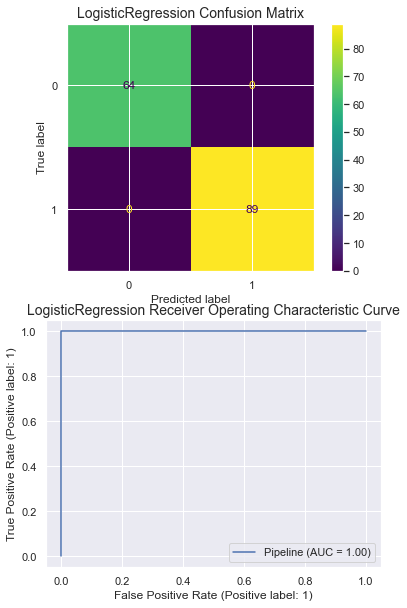

In [78]:
model, y_hat = run_model_gridsearch_CV(X_y_train_test, clf_type='log', verbose=1)

In [146]:
X = spy_cat_3Y_df.drop(['close', 'adj_close', 'open', 'high', 'low', 'volume'], axis=1)
X = X.drop(X.index[0], axis=0)
# y = y_setup.drop(y_setup.index[0]).change
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = .20,
        random_state = 729)
print (X,y)

             f_open   f_high    f_low  f_close  f_adj_close   f_volume
date                                                                  
2018-05-02  2655.50  2658.50  2624.25  2627.50      2627.50  1427995.0
2018-05-03  2626.75  2636.25  2591.25  2631.75      2631.75  2146587.0
2018-05-04  2631.75  2669.50  2612.25  2663.00      2663.00  1699202.0
2018-05-07  2662.75  2681.50  2661.25  2670.00      2670.00  1148919.0
2018-05-08  2668.00  2674.25  2652.25  2670.25      2670.25  1281751.0
...             ...      ...      ...      ...          ...        ...
2021-05-03  4181.50  4202.50  4181.00  4185.75      4185.75  1256240.0
2021-05-04  4184.25  4185.50  4120.50  4158.25      4158.25  2003587.0
2021-05-05  4158.25  4180.00  4153.00  4160.00      4160.00  1418246.0
2021-05-06  4158.75  4197.25  4140.50  4194.25      4194.25  1751616.0
2021-05-07  4197.50  4232.25  4191.75  4225.25      4225.25  1751616.0

[760 rows x 6 columns] date
2018-05-02    0
2018-05-03    0
2018-05-04    1


### SPY vs SPY Future - one day offset

In [79]:
test = [False]
if test:
    print(True)

Pmdarima_Model.py loaded from {top}/data..
regressions.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
True


In [165]:
y_setup = df_1d_back.copy()
y_setup['close_diff'] = y_setup.close.diff()
y_setup['change'] = np.where(y_setup.close_diff >= 0, 1, 0)
y_setup

,open,high,low,close,adj_close,volume,f_open,f_high,f_low,f_close,f_adj_close,f_volume,close_diff,change
date,,,,,,,,,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900.0,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0,-1.779999,0
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500.0,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0,-0.580017,0
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100.0,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0,3.399994,1
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900.0,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0,0.900024,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,417.440002,418.220001,416.809998,417.609985,417.609985,52182400.0,4129.00,4186.75,4127.50,4171.50,4171.50,1509514.0,0.869995,1
2021-04-27,417.929993,418.140015,416.299988,417.519989,417.519989,51303100.0,4170.75,4186.00,4163.75,4179.50,4179.50,1019731.0,-0.089996,0
2021-04-28,417.809998,419.010010,416.899994,417.399994,417.399994,51238900.0,4181.50,4192.50,4166.75,4179.00,4179.00,992029.0,-0.119995,0


In [167]:
X = df_1d_back.drop(['close', 'adj_close', 'open', 'high', 'low', 'volume'], axis=1)
X = X.drop(X.index[0], axis=0)
y = y_setup.drop(y_setup.index[0]).change
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = .20,
        random_state = 729)
print (X,y)

             f_open   f_high    f_low  f_close  f_adj_close   f_volume
date                                                                  
2018-05-02  2646.25  2658.00  2623.25  2652.25      2652.25  1323628.0
2018-05-03  2655.50  2658.50  2624.25  2627.50      2627.50  1427995.0
2018-05-04  2626.75  2636.25  2591.25  2631.75      2631.75  2146587.0
2018-05-07  2631.75  2669.50  2612.25  2663.00      2663.00  1699202.0
2018-05-08  2662.75  2681.50  2661.25  2670.00      2670.00  1148919.0
...             ...      ...      ...      ...          ...        ...
2021-04-26  4129.00  4186.75  4127.50  4171.50      4171.50  1509514.0
2021-04-27  4170.75  4186.00  4163.75  4179.50      4179.50  1019731.0
2021-04-28  4181.50  4192.50  4166.75  4179.00      4179.00   992029.0
2021-04-29  4180.25  4193.75  4172.75  4176.25      4176.25  1282972.0
2021-04-30  4184.75  4211.00  4168.00  4203.50      4203.50  1746965.0

[783 rows x 6 columns] date
2018-05-02    0
2018-05-03    0
2018-05-04    1


In [168]:
y.isna().sum()

0

In [169]:
numerical_pipeline = Pipeline(steps=[
    ('rs', RobustScaler())
])
                
# categorical_pipeline = Pipeline(steps=[
#     ('ohe', OneHotEncoder( #drop='first',
#                          sparse=False,
#                          handle_unknown='ignore'))
# ])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train.columns),
#     ('categorical', categorical_pipeline, X_train.columns)
])


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('rs',
                                                                   RobustScaler())]),
                                                  Index(['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close', 'f_volume'], dtype='object'))])),
                ('lr', LogisticRegression(max_iter=500, random_state=1))])
Fitting 5 folds for each of 9600 candidates, totalling 48000 fits


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning:

One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)



{'lr__C': 1.623776739188721, 'lr__class_weight': 'none', 'lr__dual': False, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
Classifier:  LogisticRegression
Num features:  6
Model score:  0.5605095541401274
Accuracy score:  0.5605095541401274
Model F1 (micro):  0.5605095541401274
Model F1 (macro):  0.3591836734693878
Model F1 (weighted):  0.4026517613414793
Cross validation score:  [0.59375    0.59375    0.41935484 0.5483871  0.58064516]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.56      1.00      0.72        88

    accuracy                           0.56       157
   macro avg       0.28      0.50      0.36       157
weighted avg       0.31      0.56      0.40       157



/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being 

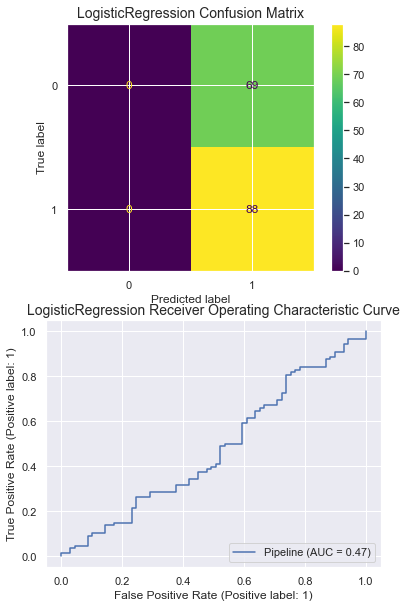

In [180]:
pipe_lr = Pipeline(steps=[
    ('trans', trans),
    ('lr', LogisticRegression(random_state=1, max_iter=500))
])
print(pipe_lr)

params_grid_lr = {'lr__penalty' : ['l1', 'l2','elasticnet'],
                  'lr__class_weight' : ['balanced', 'none'],
                  'lr__dual' : [True, False],
                  'lr__solver' : ['lbfgs', 'liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20) # only needed for elasticnet
                 }

lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=4, n_jobs=-1)

lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_clf = lr_clf.best_estimator_
model_stats(X_train.columns, best_lr_clf, 'LogisticRegression', X_test, y_test, binary=True)
Audio(sound_file, autoplay=True)

# Forecasting

## PmdArima

Successfully created instance of Class Pmdarima_Model.
Starting AutoARIMA...
Data set diffs to use: 1


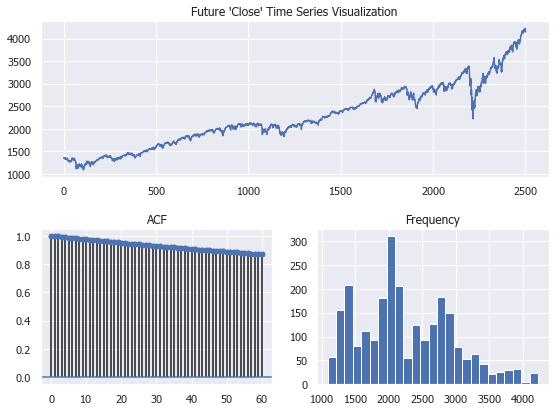

Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17126.706, Time=5.13 sec
First viable model found (17126.706)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17127.825, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17128.898, Time=0.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17128.862, Time=2.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17129.669, Time=3.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17131.962, Time=9.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17131.934, Time=2.99 sec
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Ti

> 

Done.
Test AIC: 23359.234
Test RMSE: 46.675
This is 2.327% of the avg observed value.
Test SMAPE: 0.988%

Saved best AutoARIMA model as /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/Future_'Close'_10Y_1D_AA_best_model.pkl.



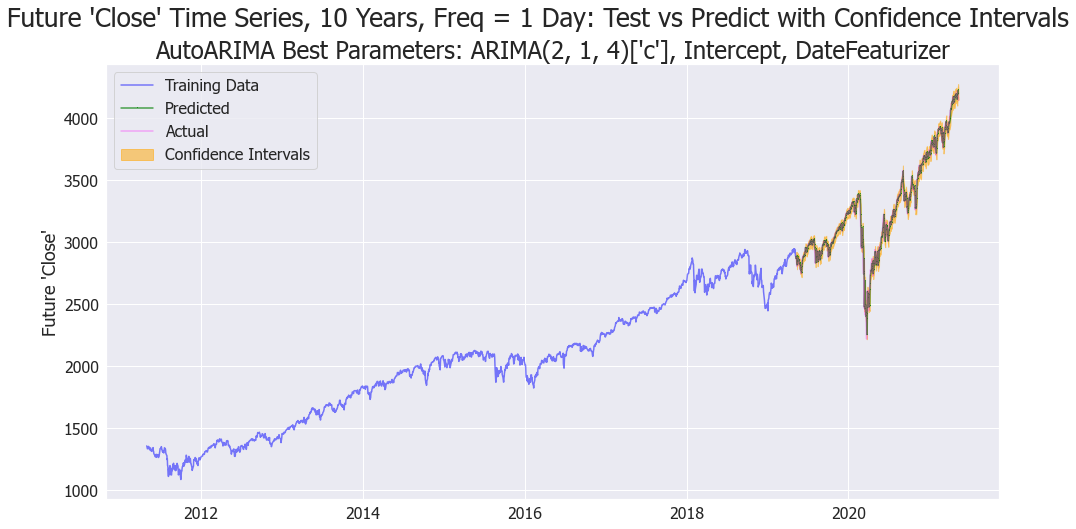

In [275]:
pam_f_close = Pmdarima_Model(df_f_10Y_close, 'Future \'Close\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=verbose,
                            date=True, fourier=False, box=False, log=False)
pam_f_close_auto = pam_f_close.run_auto_pipeline(show_summary=True, verbose=verbose, visualize=False)
pAA_CV_scores = pam_f_close.run_stepwise_CV(dynamic=False, verbose=verbose, visualize=True)
# pam_f_close_best, scores = pam_f_close.run_gridsearch_CV(max_order=1, max_d=1, min_d=1, min_p=1, min_q=0,
#                             t_list=['n'], with_intercept=False, f_m=252, k=2,
#                             date=True, fourier=False, box=False, log=False,
#                             verbose=1, debug=True, parallel=False)

### All Years, 10 Year Treasury Note

In [272]:
pam_tsy_all_10Y = Pmdarima_Model(tsy_all_df_10Y, 'TSY 10Y Note', order=(0,1,0), trend='c', with_intercept=False,
               n='All', periods='years', freq='1 Day', f_seas=252*4, k=2, fit_seas=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, 
               date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


In [246]:
pam_tsy_all_10Y_best = pam_tsy_3Y_10Y_best

In [247]:
tsy_all_10Y_hat_df, tsy_all_10Y_hat, new_dates_df, tsy_all_10Y_conf_ints = pam_tsy_all_10Y.run_prediction(pam_tsy_all_10Y_best, 52, fin=False,
                            en_ex='exog', func='adhoc', verbose=1, visualize=True)

NameError: name 'df' is not defined

## Testing

### Normal

In [189]:
opt_exp_10Y_df = create_option_expiry_df(date_index=spy_df_10Y.index, func='historical', freq=CBD)
opt_exp_fc_df = create_option_expiry_df(N=52, func='forecast', freq=CBD)

In [181]:
spy_10Y_mod_data = unpickle_data('../models/SPY_\'Close\'_3Y_1D_GS_best_model.pkl')

In [185]:
pam_10Y_close_best = spy_10Y_mod_data[1]

In [191]:
exog_10Y_fc_df = pd.Dopt_exp_fc_df
exog_10Y_hist_df = opt_exp_10Y_df

Successfully created instance of Class Pmdarima_Model.
Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 52 days forward.


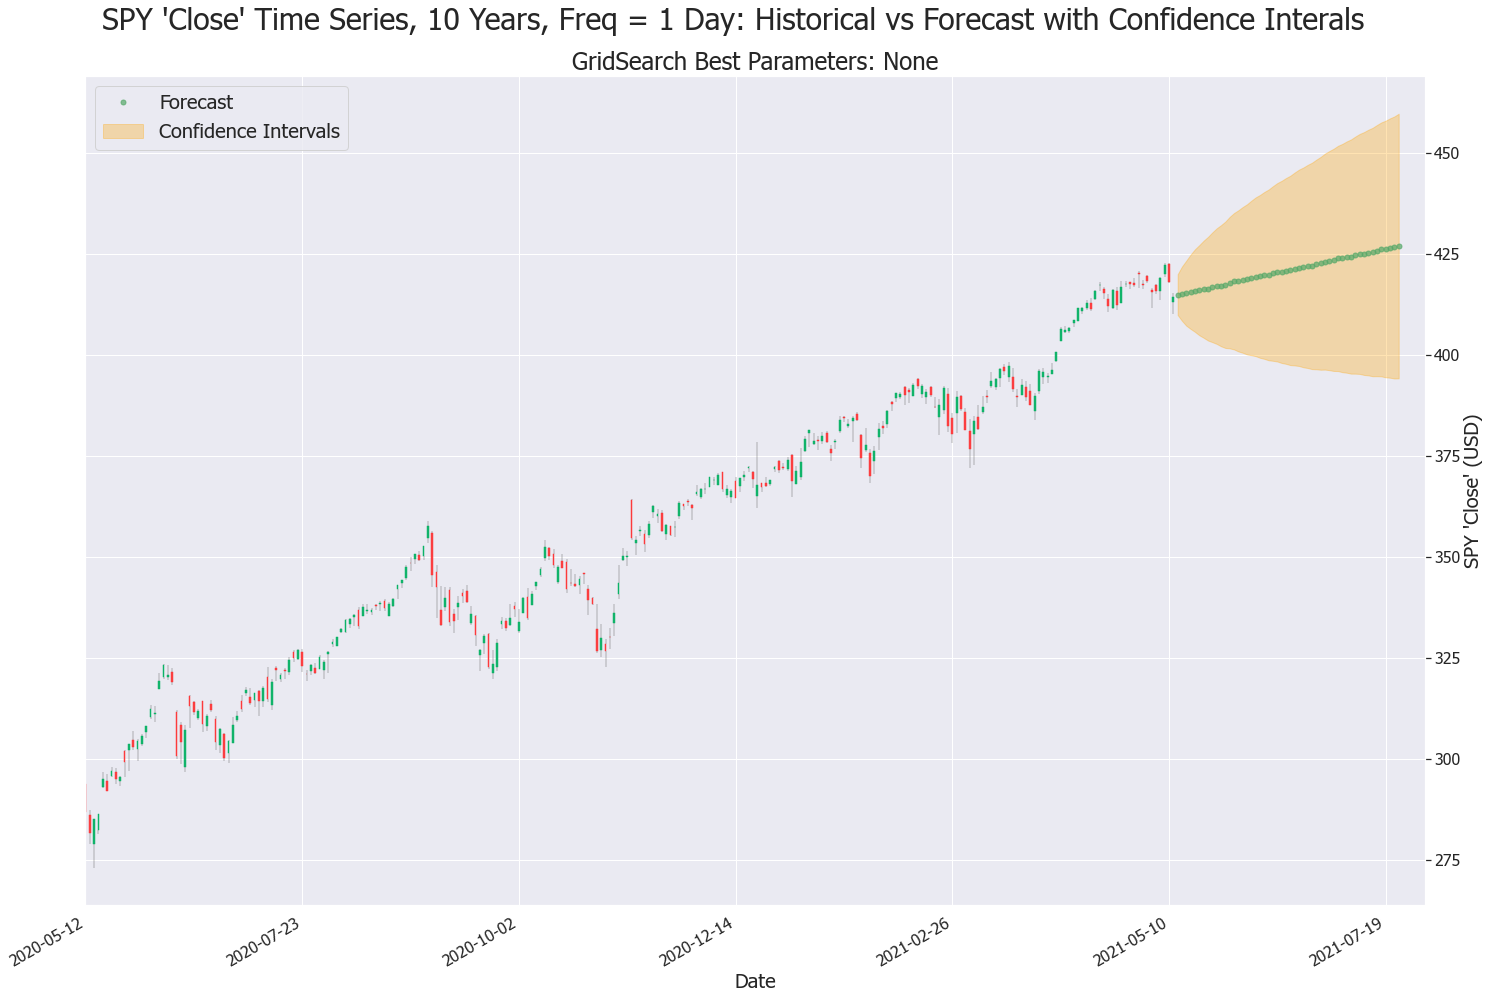

In [196]:
pam_10Y_close = Pmdarima_Model(df_10Y_close, 'SPY \'Close\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=verbose,
                            date=True, fourier=False, box=False, log=False)
close_10Y_hat_df, close_10Y_hat, new_dates_df, close_10Y_conf_ints = pam_10Y_close.run_prediction(pam_10Y_close_best, 52, fin=True,
                            exog_df=exog_10Y_fc_df, hist_df=exog_10Y_hist_df, en_ex='endo', ohlc_df=spy_df_10Y,
                            func='GS', lookback=252, verbose=1, visualize=True)

In [ ]:
fig, ax = plt.subplots(figsize=(24, 16))
    if fin:
        mpl.plot(ohlc_df[-lookback:], type='candle', style="yahoo", ax=ax)
        ax.plot(range(lookback, lookback+days_fc), y_hat, 'g.', markersize=10, alpha=0.7, label='Forecast')
        # ax.set_xlim(0, lookback+lookback//10)
        ax.set_xlim(0, lookback+days_fc+5)
        equidate_ax(fig, ax, self.df_with_fc[-lookback-days_fc:].index.date)
        ax.set_xlabel(f'Date', size=20)
        
        mpl.plot(ohlc_fc_df, type='candle', style="yahoo", ax=ax)
        equidate_ax(fig, ax, self.df_with_fc[-lookback-days_fc:].index.date)
        ax.set_xlabel(f'Date', size=20)

In [280]:
new_mod = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=4, m=252)),
                ('fourier2', pm.preprocessing.FourierFeaturizer(k=4, m=252*4)),
                ('fourier3', pm.preprocessing.FourierFeaturizer(k=4, m=252/4)),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(4, 1, 6), suppress_warnings=True,
                       trend='t'))])

Successfully created instance of Class Pmdarima_Model.
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('fourier2', FourierFeaturizer(k=4, m=1008)),
                ('fourier3', FourierFeaturizer(k=4, m=63.0)),
                ('arima',
                 ARIMA(maxiter=200, order=(4, 1, 6), suppress_warnings=True,
                       trend='t'))])
Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 52 days forward.


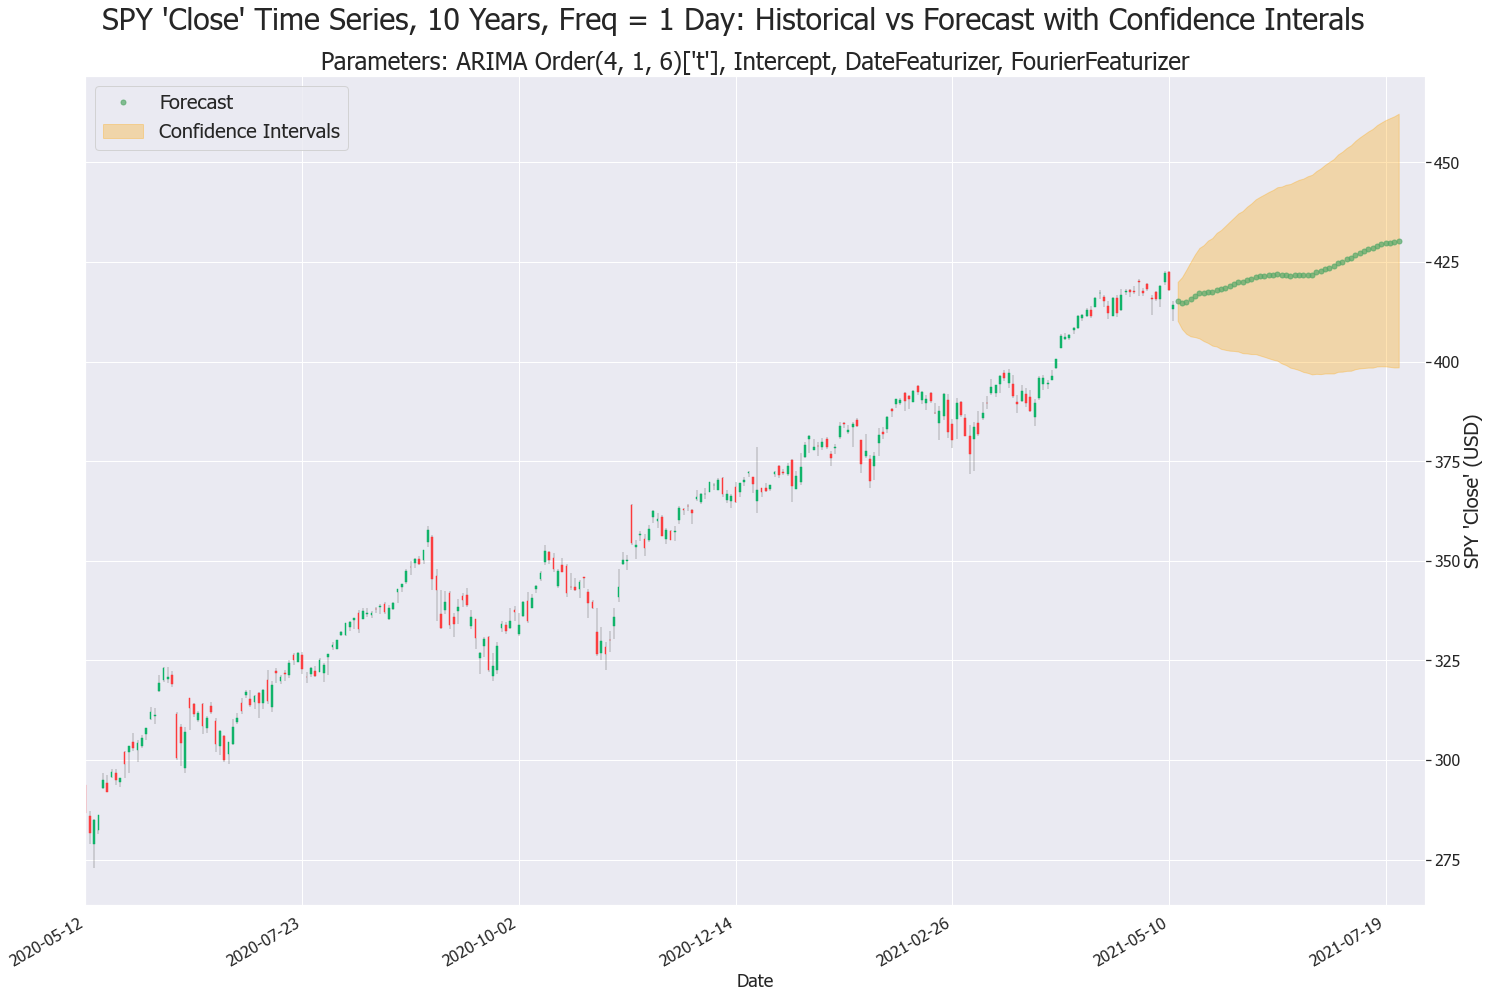

In [284]:
# higher order model with three seasonalities
pam_10Y_close = Pmdarima_Model(df_10Y_close, 'SPY \'Close\'', train_size=80, order=(4,1,6),
                            n=10, periods='years', freq='1 Day', seas=252, trend='t', with_intercept=True,
                            estimate_diffs=True, impute=False, verbose=verbose, f_seas=252, k=2,
                            date=True, fourier=True, box=False, log=False)
print(new_mod)
close_10Y_hat_df, close_10Y_hat, new_dates_df, close_10Y_conf_ints = pam_10Y_close.run_prediction(model=new_mod, days_fc=52, fin=True,
                            exog_df=exog_10Y_fc_df, hist_df=exog_10Y_hist_df, en_ex='endo', ohlc_df=spy_df_10Y,
                            func='adhoc', lookback=252, verbose=1, visualize=True)

In [285]:
(close_10Y_conf_ints[0][1] - close_10Y_conf_ints[0][0])/df_10Y_close[-1]

0.023578820168461356

In [ ]:
new_mod2 = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=2, m=252)),
                ('fourier2', pm.preprocessing.FourierFeaturizer(k=2, m=252*4)),
                ('fourier3', pm.preprocessing.FourierFeaturizer(k=2, m=252/4)),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])

Successfully created instance of Class Pmdarima_Model.
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('fourier2', FourierFeaturizer(k=2, m=1008)),
                ('fourier3', FourierFeaturizer(k=2, m=63.0)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 52 days forward.


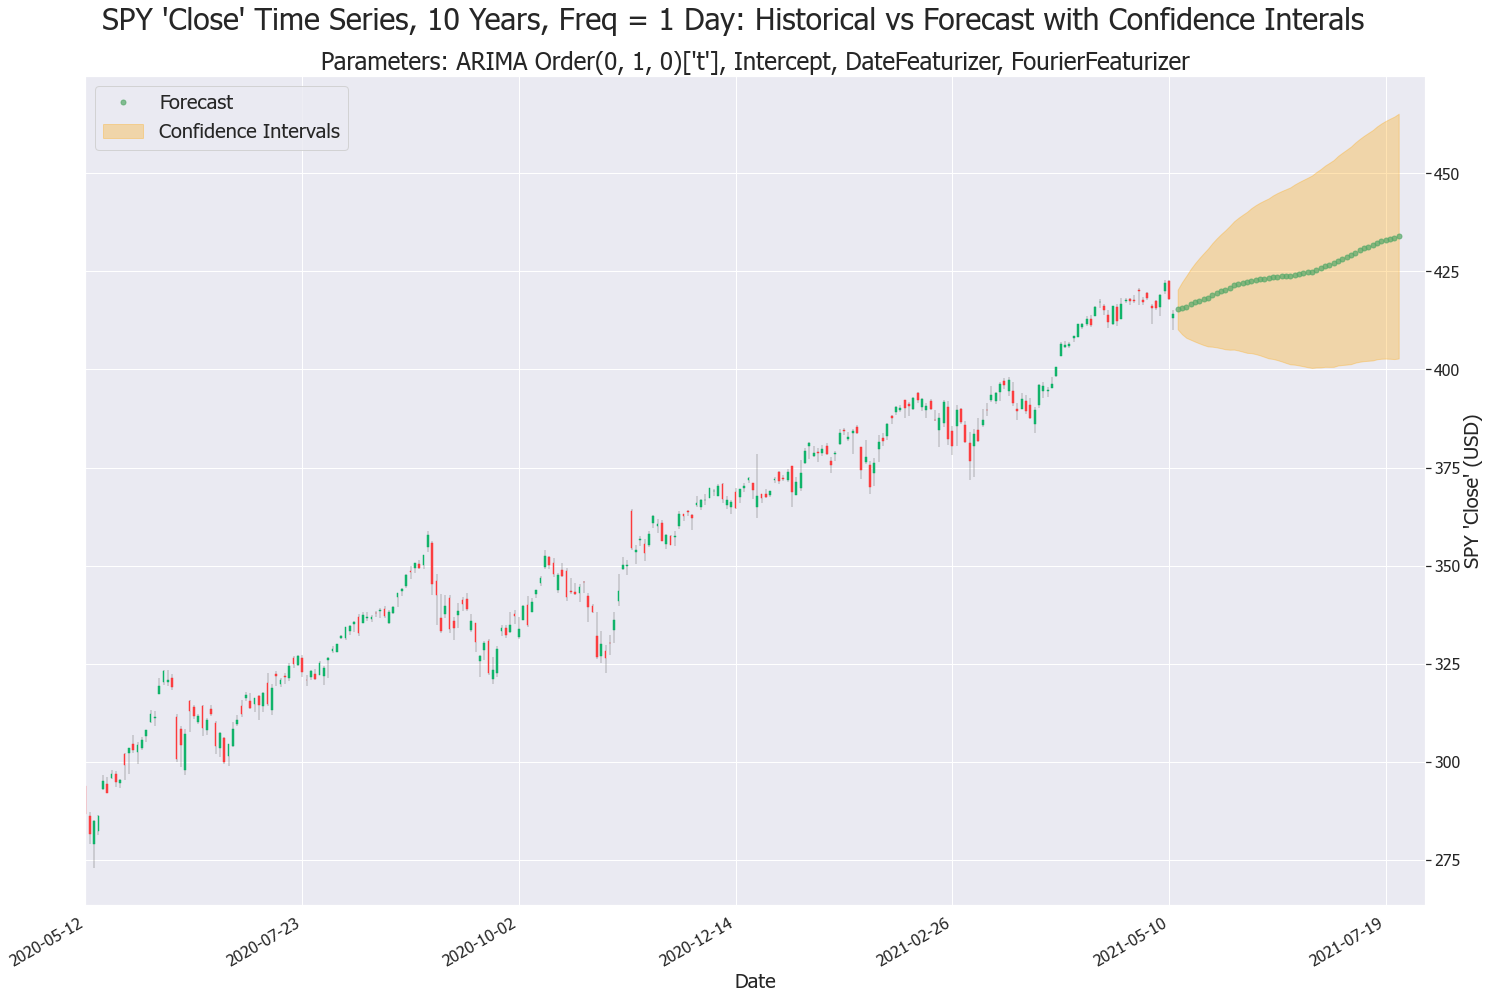

In [250]:
# lower order model with three seasonalities
pam_10Y_close = Pmdarima_Model(df_10Y_close, 'SPY \'Close\'', train_size=80, order=(0,1,0),
                            n=10, periods='years', freq='1 Day', seas=252, trend='t', with_intercept=True,
                            estimate_diffs=True, impute=False, verbose=verbose, f_seas=252, k=2,
                            date=True, fourier=True, box=False, log=False)
print(new_mod2)
close_10Y_hat_df, close_10Y_hat, new_dates_df, close_10Y_conf_ints = pam_10Y_close.run_prediction(model=new_mod2, days_fc=52, fin=True,
                            exog_df=exog_10Y_fc_df, hist_df=exog_10Y_hist_df, en_ex='endo', ohlc_df=spy_df_10Y,
                            func='adhoc', lookback=252, verbose=1, visualize=True)

In [279]:
(close_10Y_conf_ints[0][1] - close_10Y_conf_ints[0][0])/df_10Y_close[-1]

0.024341355803493447

### Step-Wise

In [241]:
# Was not accurate

## Linear